# **Loan Default Prediction**


## **Problem Definition**

### **The Context: Why is this Problem Important?**

Loan defaults can significantly affect a bank's profitability and operational stability. A large share of profits in retail banking stems from home equity loans, but the threat of Non-Performing Assets (NPAs) due to loan defaults makes risk assessment crucial. Traditionally, creditworthiness assessments rely on manual processes, which are not only time-consuming and inconsistent but also susceptible to human biases and errors.

#### **Additional Business Perspective**
From a strategic point of view, automating and optimizing credit risk evaluation brings:
- **Operational efficiency** – reducing processing time and manpower requirements.
- **Improved risk management** – avoiding bad loans improves balance sheet health.
- **Regulatory alignment** – adhering to frameworks like the Equal Credit Opportunity Act ensures fair lending practices.
- **Competitive advantage** – faster and more accurate decisions enhance customer experience and loyalty.

### **The Objectives: What is the Goal?**

The primary goal is to build a binary classification model that predicts whether a loan applicant is likely to default (BAD = 1) or repay (BAD = 0), using the features available at the time of loan application.

#### **Extended Objective View**
- Proactively **identify high-risk applicants** before loan disbursal.
- Offer **interpretable and explainable** decisions to justify loan denials.
- Generate **feature-based recommendations** for refining the bank's approval policy.
- Aid in **bias mitigation** by ensuring that historical discrimination does not propagate through the model.

### **The Key Questions**

- Which variables are most predictive of loan default?
- What is the best performing model (accuracy vs interpretability) for this problem?
- How can the model be validated for fairness and generalizability?
- What steps should the bank take based on model insights?
- Can we balance business objectives (low false negatives) with regulatory fairness?

### **The Problem Formulation: Data Science View**

This problem is a supervised binary classification task. Given historical data on loan applications and their outcomes, we aim to:

- Train a model to predict the `BAD` label based on input features like income, employment status, existing debts, property value, and more.
- **Focus on predicting `BAD = 1` (loan default), since the business impact of lending to defaulters is high.**
- **Minimize False Negatives (i.e., cases where a defaulter is incorrectly classified as non-defaulter), which represent the costliest errors.**
- Evaluate models using classification metrics (e.g., ROC-AUC, Recall, Precision-Recall Curve, F1-Score) appropriate for imbalanced datasets.
- Emphasize model interpretability (e.g., using logistic regression, decision trees, SHAP) to support business deployment.


## **Data Description:**
The Home Equity dataset (HMEQ) contains baseline and loan performance information for 5,960 recent home equity loans. The target (BAD) is a binary variable that indicates whether an applicant has ultimately defaulted or has been severely delinquent. This adverse outcome occurred in 1,189 cases (20 percent). 12 input variables were registered for each applicant.


* **BAD:** 1 = Client defaulted on loan, 0 = loan repaid

* **LOAN:** Amount of loan approved.

* **MORTDUE:** Amount due on the existing mortgage.

* **VALUE:** Current value of the property. 

* **REASON:** Reason for the loan request. (HomeImp = home improvement, DebtCon= debt consolidation which means taking out a new loan to pay off other liabilities and consumer debts) 

* **JOB:** The type of job that loan applicant has such as manager, self, etc.

* **YOJ:** Years at present job.

* **DEROG:** Number of major derogatory reports (which indicates a serious delinquency or late payments). 

* **DELINQ:** Number of delinquent credit lines (a line of credit becomes delinquent when a borrower does not make the minimum required payments 30 to 60 days past the day on which the payments were due). 

* **CLAGE:** Age of the oldest credit line in months. 

* **NINQ:** Number of recent credit inquiries. 

* **CLNO:** Number of existing credit lines.

* **DEBTINC:** Debt-to-income ratio (all your monthly debt payments divided by your gross monthly income. This number is one way lenders measure your ability to manage the monthly payments to repay the money you plan to borrow.

## **Import the necessary libraries and Data**

In [34]:


# Import necessary libraries
from sklearn.feature_selection import SelectKBest
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import (
    train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
)
from sklearn.pipeline import Pipeline as SklearnPipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer, classification_report
)

import scipy.stats as st
from mlxtend.evaluate import mcnemar_table, mcnemar, cochrans_q
import pingouin as pg
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:


# Load dataset
df = pd.read_csv('hmeq.csv')
df.head()


,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN



# Data overview: shape, types, nulls, duplicates


In [9]:

# Data overview: shape, types, nulls, duplicates
print("Shape of dataset:", df.shape)
print("\nData Types:")
print(df.dtypes)



Shape of dataset: (5960, 13)

Data Types:
BAD          int64
LOAN         int64
MORTDUE    float64
VALUE      float64
REASON      object
JOB         object
YOJ        float64
DEROG      float64
DELINQ     float64
CLAGE      float64
NINQ       float64
CLNO       float64
DEBTINC    float64
dtype: object


In [12]:
print("\nMissing Values Check:")
missing_values = df.isnull().sum()
print(missing_values)

print("\nNumber of Duplicate Rows:")
print(df.duplicated().sum())


Missing Values Check:
BAD           0
LOAN          0
MORTDUE     518
VALUE       112
REASON      252
JOB         279
YOJ         515
DEROG       708
DELINQ      580
CLAGE       308
NINQ        510
CLNO        222
DEBTINC    1267
dtype: int64

Number of Duplicate Rows:
0


In [13]:
missing_like = ['NA', 'N/A', 'na', 'n/a', 'null', 'NULL', '', ' ', None]

for col in df.columns:
    missing_count = df[col].isin(missing_like).sum()
    if missing_count > 0:
        print(f"{col} has {missing_count} suspicious missing-like values.")

In [14]:
for col in df.select_dtypes(include='object'):
    stripped = df[col].astype(str).str.strip()
    print(f"{col}: {(stripped == '').sum()} empty strings after strip.")

REASON: 0 empty strings after strip.
JOB: 0 empty strings after strip.


In [15]:
print("\nUnique Values per Column:")
print(df.nunique())


Unique Values per Column:
BAD           2
LOAN        540
MORTDUE    5053
VALUE      5381
REASON        2
JOB           6
YOJ          99
DEROG        11
DELINQ       14
CLAGE      5314
NINQ         16
CLNO         62
DEBTINC    4693
dtype: int64


## Summary Statistics

In [12]:

# Summary statistics
print("\nStatistical Summary:\n", df.describe())




Statistical Summary:
                BAD          LOAN        MORTDUE          VALUE          YOJ  \
count  5960.000000   5960.000000    5442.000000    5848.000000  5445.000000   
mean      0.199497  18607.969799   73760.817200  101776.048741     8.922268   
std       0.399656  11207.480417   44457.609458   57385.775334     7.573982   
min       0.000000   1100.000000    2063.000000    8000.000000     0.000000   
25%       0.000000  11100.000000   46276.000000   66075.500000     3.000000   
50%       0.000000  16300.000000   65019.000000   89235.500000     7.000000   
75%       0.000000  23300.000000   91488.000000  119824.250000    13.000000   
max       1.000000  89900.000000  399550.000000  855909.000000    41.000000   

             DEROG       DELINQ        CLAGE         NINQ         CLNO  \
count  5252.000000  5380.000000  5652.000000  5450.000000  5738.000000   
mean      0.254570     0.449442   179.766275     1.186055    21.296096   
std       0.846047     1.127266    85.81009

In [13]:
# Initial Observations
print("\n### Initial Observations")
print("Range of numerical attributes:")
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    print(f"{column}: Min = {df[column].min()}, Max = {df[column].max()}")


### Initial Observations
Range of numerical attributes:
BAD: Min = 0, Max = 1
LOAN: Min = 1100, Max = 89900
MORTDUE: Min = 2063.0, Max = 399550.0
VALUE: Min = 8000.0, Max = 855909.0
YOJ: Min = 0.0, Max = 41.0
DEROG: Min = 0.0, Max = 10.0
DELINQ: Min = 0.0, Max = 15.0
CLAGE: Min = 0.0, Max = 1168.2335609
NINQ: Min = 0.0, Max = 17.0
CLNO: Min = 0.0, Max = 71.0
DEBTINC: Min = 0.5244992154, Max = 203.31214869


## Observations Summary Statistics

**Correlation Insights:**
- **DELINQ** (delinquent credit lines) shows a moderate positive correlation (0.354) with **BAD** (loan default), indicating a higher number of delinquencies may be associated with defaults.
- **DEROG** (major derogatory reports) correlates positively (0.276) with **BAD**, suggesting its potential as a risk indicator.
- Other features like **LOAN**, **MORTDUE**, and **VALUE** are strongly inter-correlated, which may imply multicollinearity issues that need attention during modeling.

**Data Quality and Missing Values:**
- The main DataFrame has complete records for loan performance and applicant details, but the *outliers* subset reveals missing values in fields like **DEBTINC** and some categorical variables.
- Missing observations in variables such as **MORTDUE**, **VALUE**, **JOB**, etc., are evident in the *outliers* DataFrame, which might affect model training if not properly imputed.

**Outlier Detection:**
- The *outliers* DataFrame contains 1201 records, emphasizing the need for careful treatment of extreme values, especially in features like **DELINQ**, **DEROG**, and **DEBTINC**.

**General Observations:**
- The dataset contains 5960 records with 13 attributes, combining both numerical and categorical data.
- Attention should be paid to handling multicollinearity and the imputation of missing values to ensure robust model performance.

## Treating Outliers

In [16]:

def plot_numerical_outliers(df, column):
    """
    Plots histogram with KDE and boxplot for a numerical column
    with IQR-based outlier thresholds.
    """
    data = df[column].dropna()
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    sns.histplot(data, kde=True, ax=axes[0], color='skyblue', bins=20)
    axes[0].axvline(lower_bound, color='red', linestyle='--', label='Lower Bound')
    axes[0].axvline(upper_bound, color='green', linestyle='--', label='Upper Bound')
    axes[0].set_title(f"Histogram of {column}")
    axes[0].legend()

    sns.boxplot(x=data, ax=axes[1], color='steelblue')
    axes[1].axvline(lower_bound, color='red', linestyle='--')
    axes[1].axvline(upper_bound, color='green', linestyle='--')
    axes[1].set_title(f"Boxplot of {column}")

    plt.tight_layout()
    plt.show()

    print(f"\n{column} IQR Outlier Boundaries:")
    print(f" - Lower Bound: {lower_bound:.2f}")
    print(f" - Upper Bound: {upper_bound:.2f}")
    print(f" - Outliers below lower bound: {(data < lower_bound).sum()}")
    print(f" - Outliers above upper bound: {(data > upper_bound).sum()}")


 Analyzing: BAD


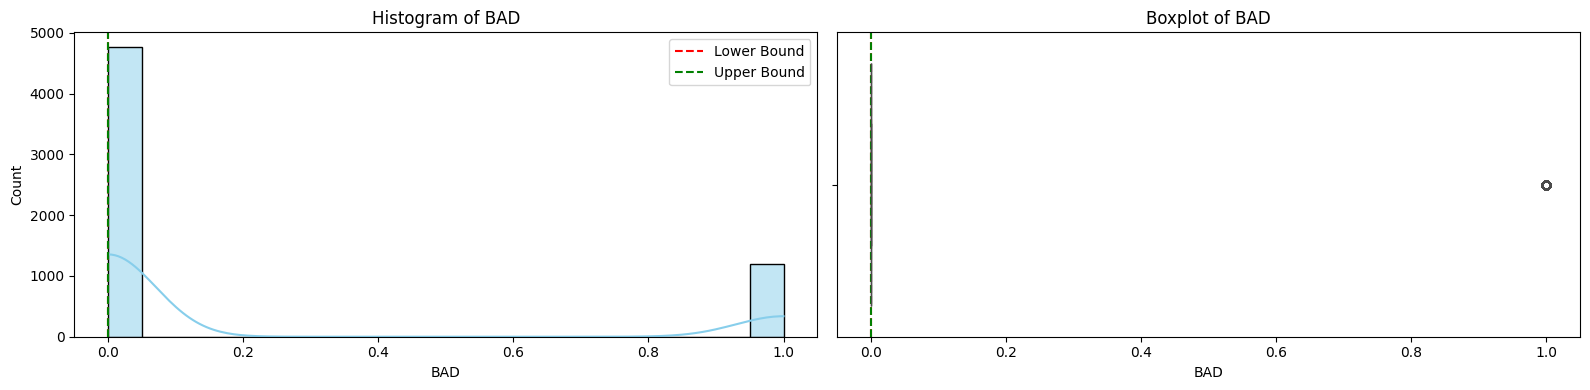


BAD IQR Outlier Boundaries:
 - Lower Bound: 0.00
 - Upper Bound: 0.00
 - Outliers below lower bound: 0
 - Outliers above upper bound: 1189

 Analyzing: LOAN


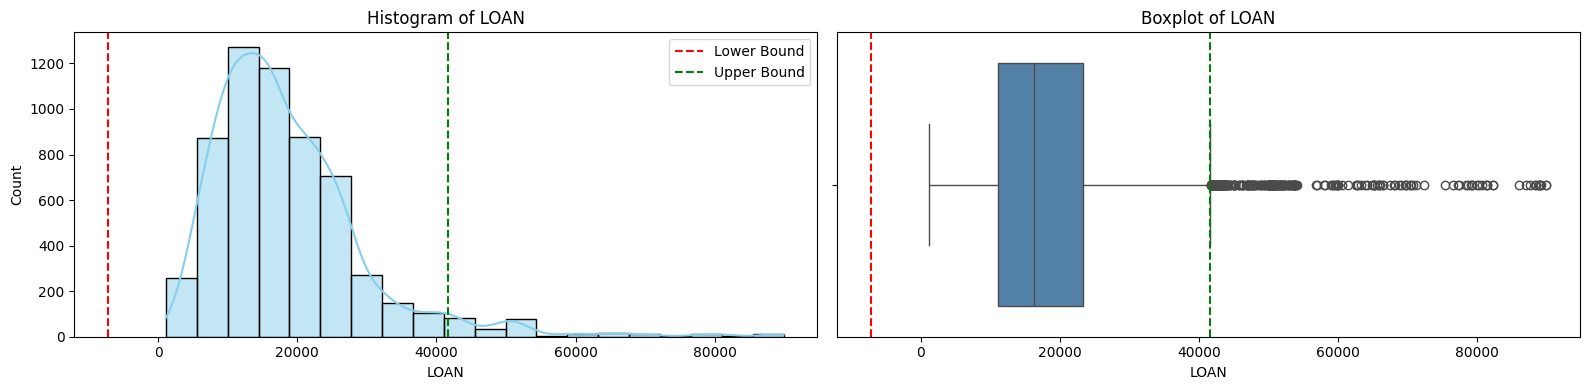


LOAN IQR Outlier Boundaries:
 - Lower Bound: -7200.00
 - Upper Bound: 41600.00
 - Outliers below lower bound: 0
 - Outliers above upper bound: 256

 Analyzing: MORTDUE


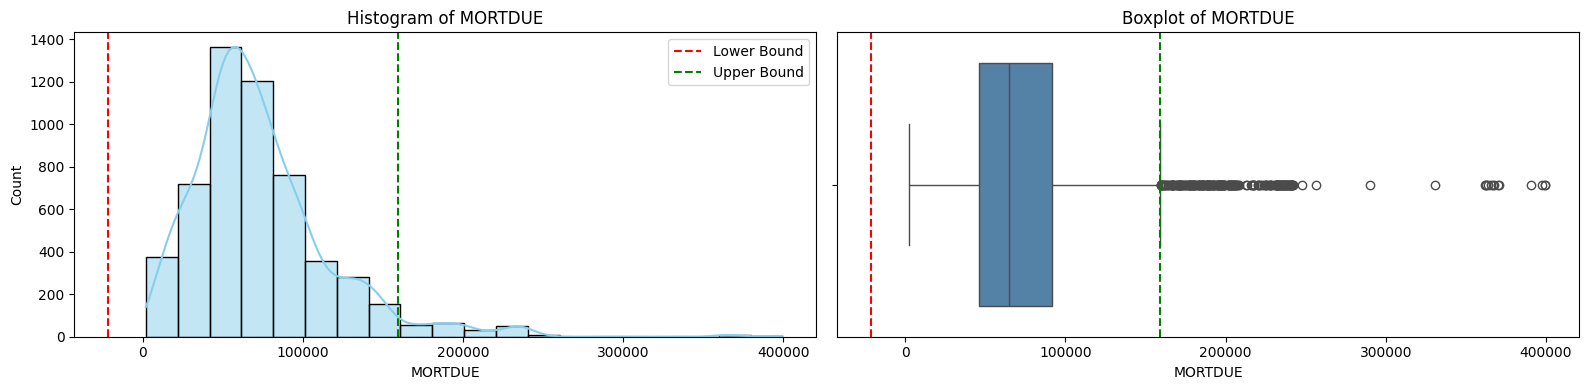


MORTDUE IQR Outlier Boundaries:
 - Lower Bound: -21542.00
 - Upper Bound: 159306.00
 - Outliers below lower bound: 0
 - Outliers above upper bound: 234

 Analyzing: VALUE


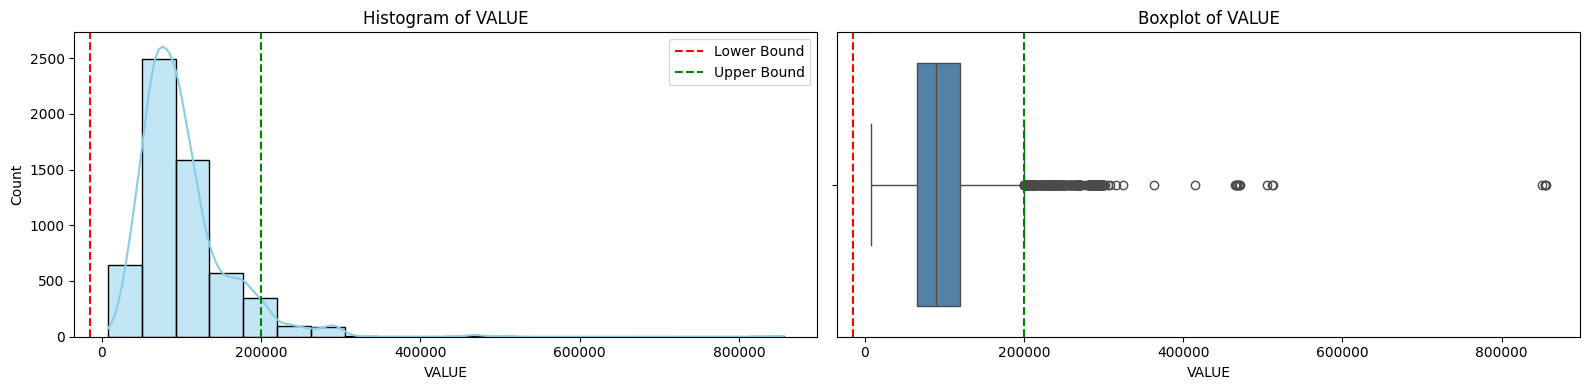


VALUE IQR Outlier Boundaries:
 - Lower Bound: -14547.62
 - Upper Bound: 200447.38
 - Outliers below lower bound: 0
 - Outliers above upper bound: 320

 Analyzing: YOJ


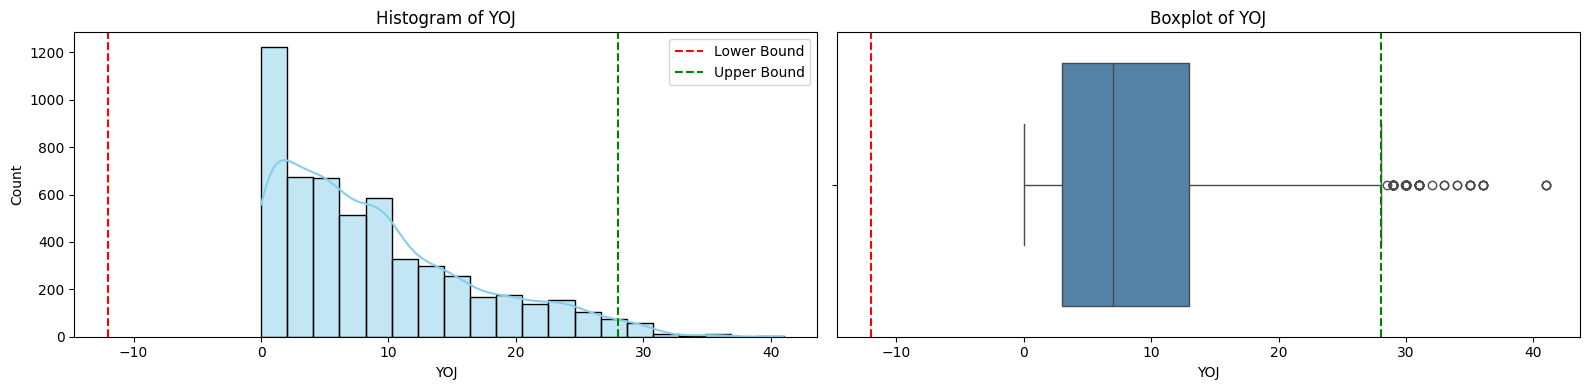


YOJ IQR Outlier Boundaries:
 - Lower Bound: -12.00
 - Upper Bound: 28.00
 - Outliers below lower bound: 0
 - Outliers above upper bound: 91

 Analyzing: DEROG


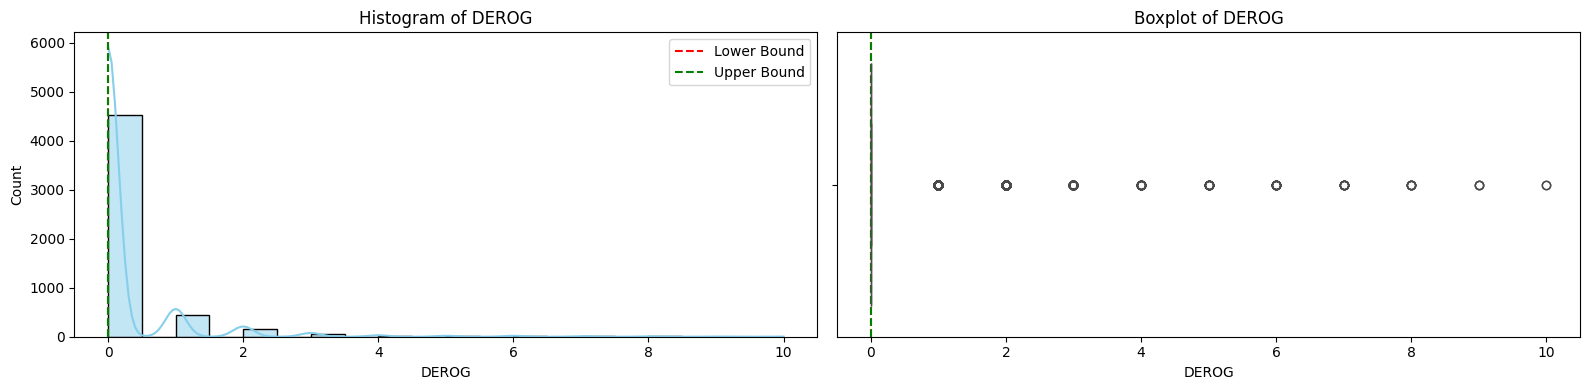


DEROG IQR Outlier Boundaries:
 - Lower Bound: 0.00
 - Upper Bound: 0.00
 - Outliers below lower bound: 0
 - Outliers above upper bound: 725

 Analyzing: DELINQ


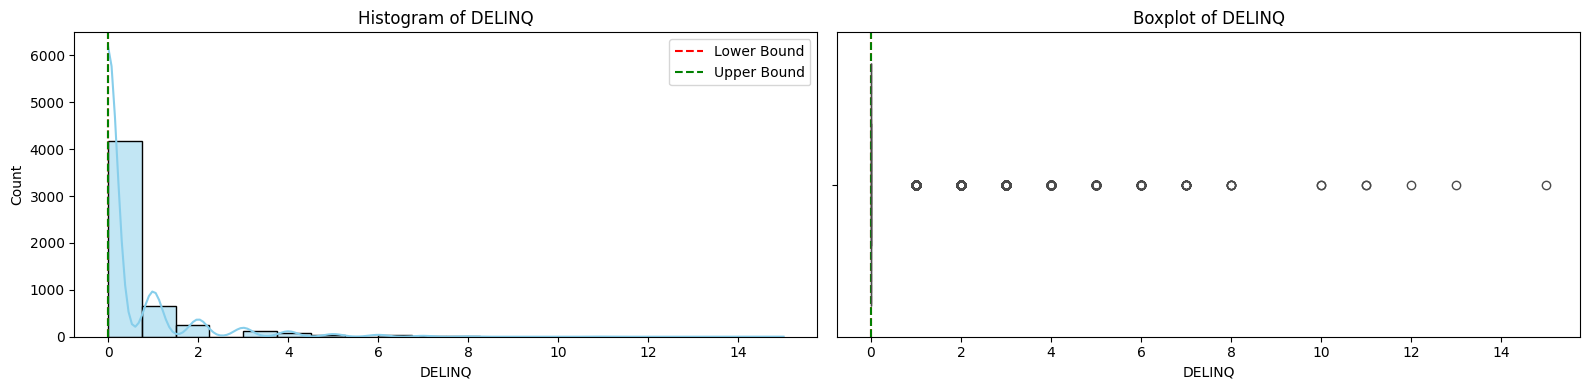


DELINQ IQR Outlier Boundaries:
 - Lower Bound: 0.00
 - Upper Bound: 0.00
 - Outliers below lower bound: 0
 - Outliers above upper bound: 1201

 Analyzing: CLAGE


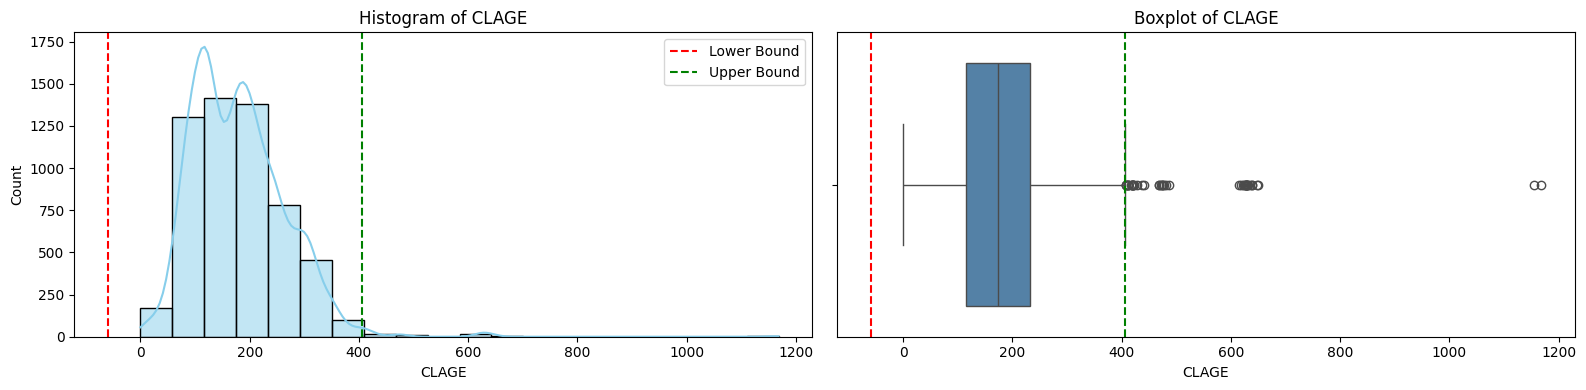


CLAGE IQR Outlier Boundaries:
 - Lower Bound: -59.55
 - Upper Bound: 406.23
 - Outliers below lower bound: 0
 - Outliers above upper bound: 47

 Analyzing: NINQ


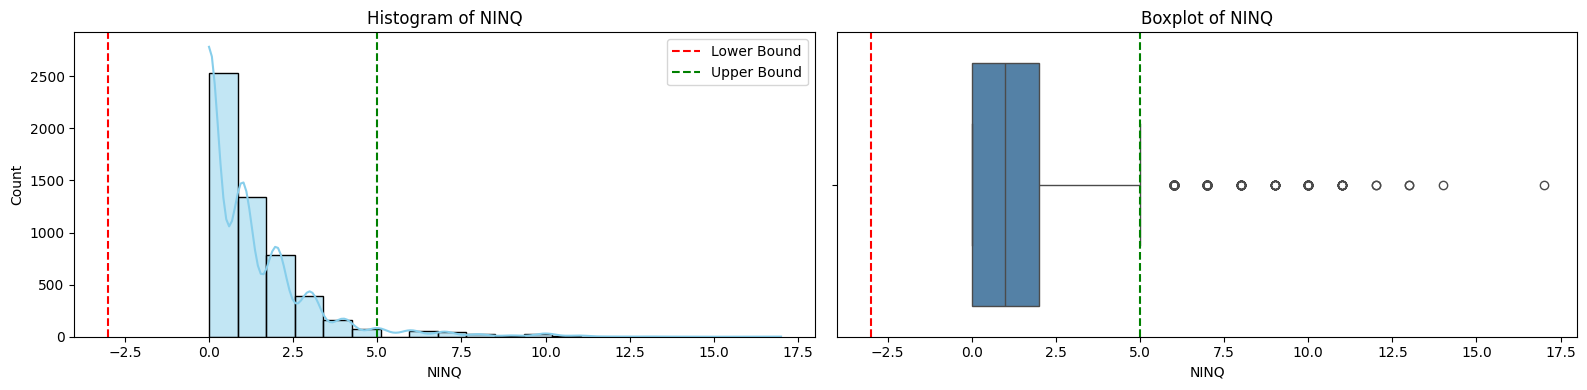


NINQ IQR Outlier Boundaries:
 - Lower Bound: -3.00
 - Upper Bound: 5.00
 - Outliers below lower bound: 0
 - Outliers above upper bound: 177

 Analyzing: CLNO


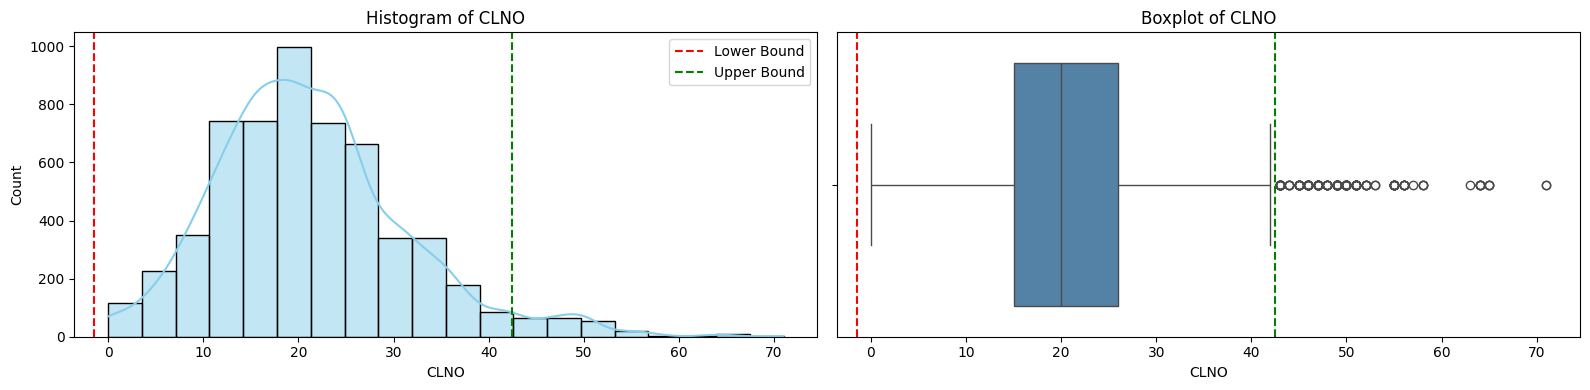


CLNO IQR Outlier Boundaries:
 - Lower Bound: -1.50
 - Upper Bound: 42.50
 - Outliers below lower bound: 0
 - Outliers above upper bound: 219

 Analyzing: DEBTINC


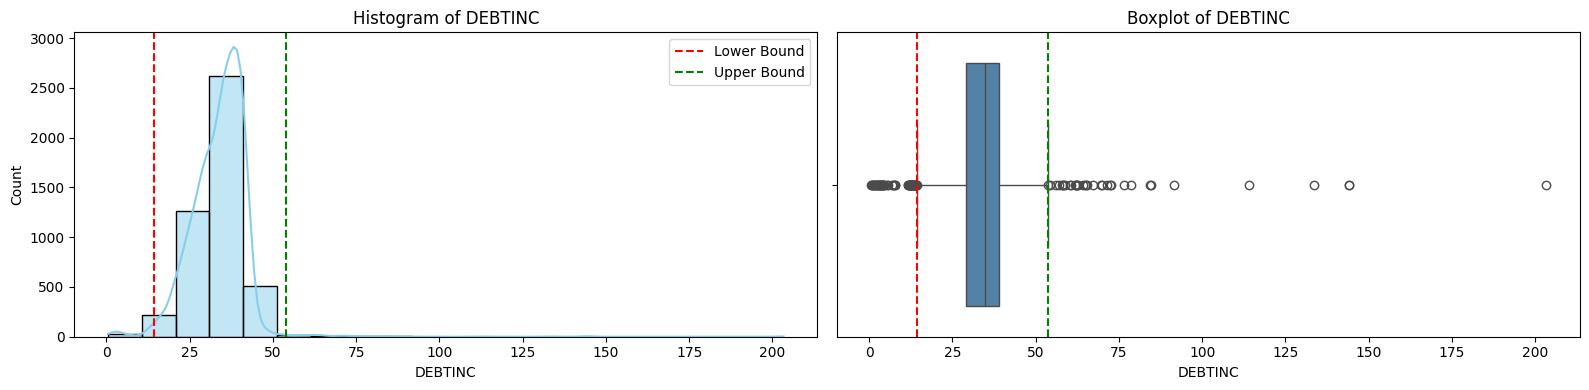


DEBTINC IQR Outlier Boundaries:
 - Lower Bound: 14.35
 - Upper Bound: 53.80
 - Outliers below lower bound: 59
 - Outliers above upper bound: 35


In [17]:
def plot_all_numerical_outliers(df):
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    for col in numerical_cols:
        print(f"\n Analyzing: {col}")
        plot_numerical_outliers(df, col)

# Execute the full analysis
plot_all_numerical_outliers(df)

In [14]:
# Detect outliers using IQR for selected numerical features
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower) | (data[column] > upper)]
    return outliers

for col in ['DEBTINC', 'DEROG', 'DELINQ']:
    outliers = detect_outliers_iqr(df, col)
    print(f"{col}: {len(outliers)} outliers detected")

DEBTINC: 94 outliers detected
DEROG: 725 outliers detected
DELINQ: 1201 outliers detected


## Treating Missing Values

In [15]:
# Handle missing values
# Check for missing values again
# Fill numerical columns with their median
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    if df[column].isnull().sum() > 0:
        df[column].fillna(df[column].median(), inplace=True)

# Fill categorical columns with their mode
for column in df.select_dtypes(include=['object']).columns:
    if df[column].isnull().sum() > 0:
        df[column].fillna(df[column].mode()[0], inplace=True)

# Verify missing values are handled
print("\n### Missing Values After Treatment")
print(df.isnull().sum())

# Observations
print("\n### Observations:")
print("1. Missing values in numerical columns were filled with their median.")
print("2. Missing values in categorical columns were filled")


### Missing Values After Treatment
BAD        0
LOAN       0
MORTDUE    0
VALUE      0
REASON     0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64

### Observations:
1. Missing values in numerical columns were filled with their median.
2. Missing values in categorical columns were filled

BAD        0
LOAN       0
MORTDUE    0
VALUE      0
REASON     0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64

### Observations:
1. Missing values in numerical columns were filled with their median.
2. Missing values in categorical columns were filled


### **Why Use Median for Numerical Columns?**
- The **median** is a robust measure of central tendency that is not affected by extreme values (outliers).
- Using the median ensures that the imputed value represents the central value of the data distribution without being skewed by outliers.
- This approach is particularly useful when the numerical data contains outliers or is not normally distributed.

### **Why Use Mode for Categorical Columns?**
- The **mode** represents the most frequently occurring value in a categorical column.
- Filling missing values with the mode ensures that the imputed value aligns with the most common category in the data.
- This approach maintains the integrity of the categorical distribution and avoids introducing new or unrealistic categories.

### **Conclusion**
- By using the median for numerical columns and the mode for categorical columns, we ensure that the missing value treatment is both statistically sound and preserves the original data distribution as much as possible.

## **Exploratory Data Analysis (EDA) and Visualization**

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

**Leading Questions**:
1. What is the range of values for the loan amount variable "LOAN"?
2. How does the distribution of years at present job "YOJ" vary across the dataset?
3. How many unique categories are there in the REASON variable?
4. What is the most common category in the JOB variable?
5. Is there a relationship between the REASON variable and the proportion of applicants who defaulted on their loan?
6. Do applicants who default have a significantly different loan amount compared to those who repay their loan?
7. Is there a correlation between the value of the property and the loan default rate?
8. Do applicants who default have a significantly different mortgage amount compared to those who repay their loan?

### **Univariate Analysis**


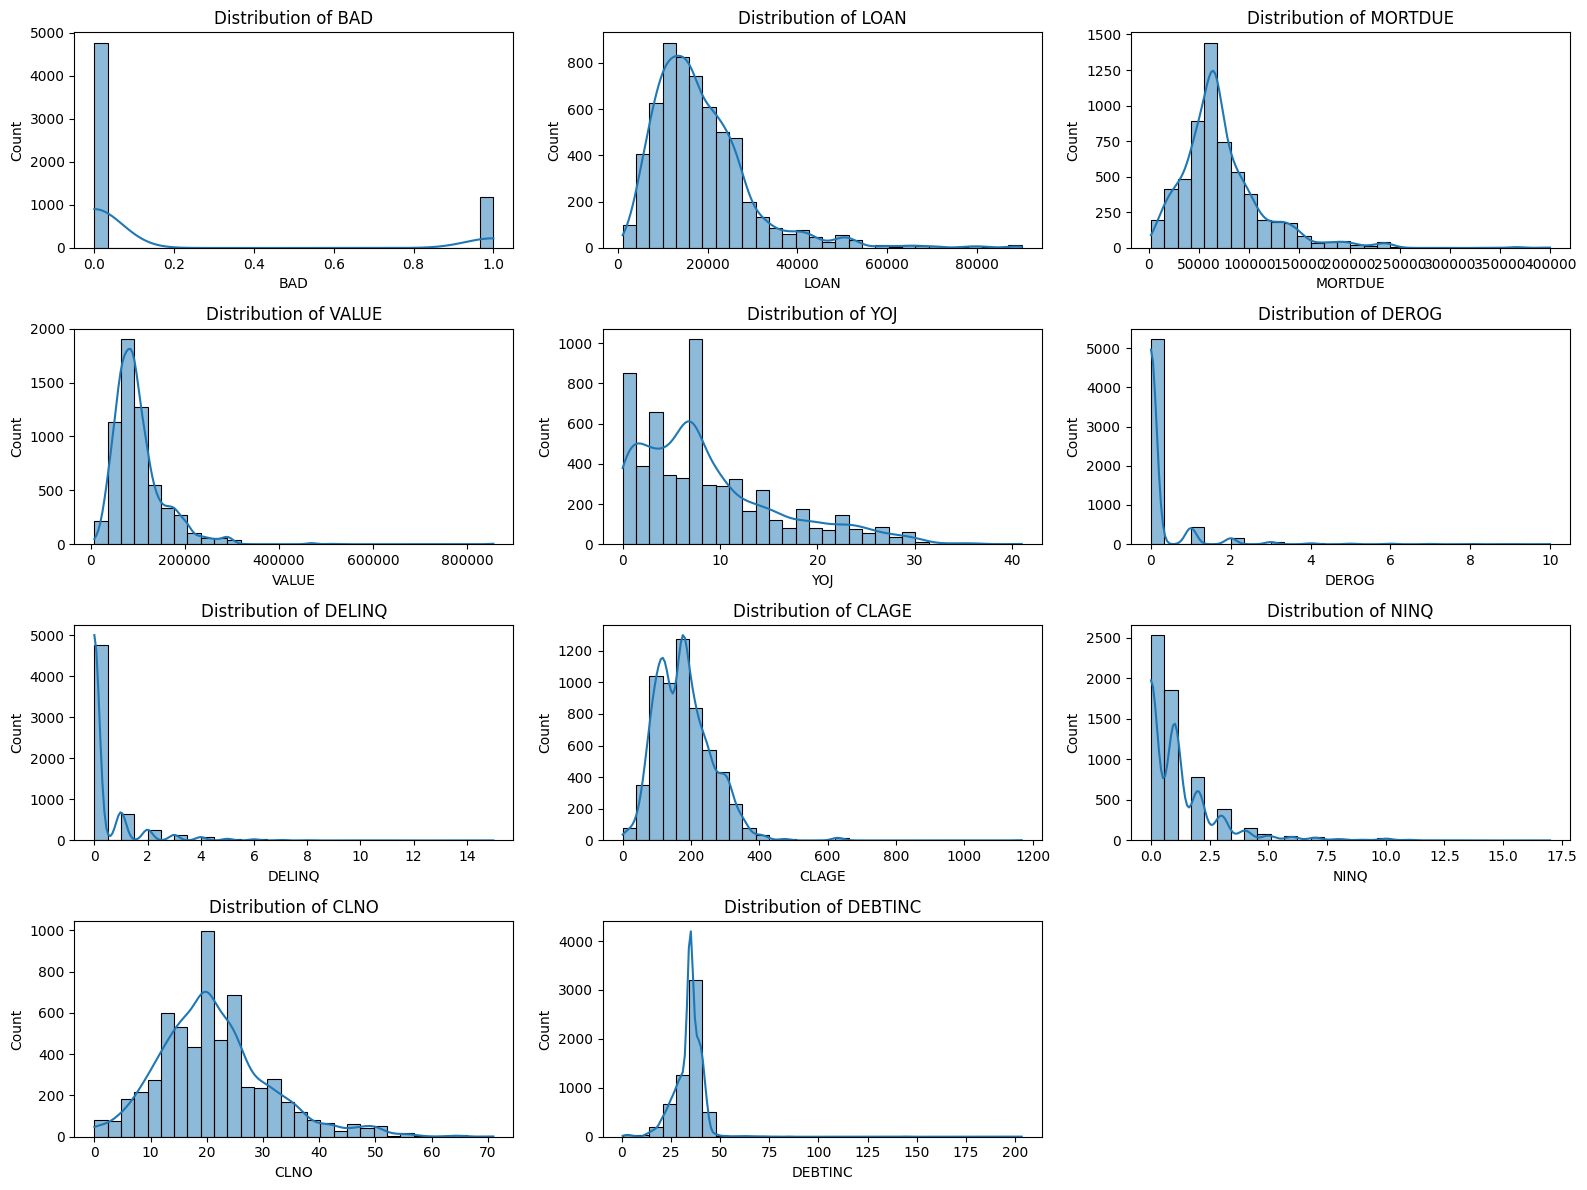

In [16]:

# Univariate analysis: Distribution of numerical columns
num_cols = df.select_dtypes(include=[np.number]).columns

plt.figure(figsize=(16, 12))
for i, col in enumerate(num_cols):
    plt.subplot(4, 3, i + 1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


### Univariate Analysis Observations

1. **Continuous Monetary Variables:**
    - Variables such as LOAN, MORTDUE, and VALUE exhibit right-skewed distributions, with most observations concentrated at the lower end and a long tail indicating few very high amounts.
    - The spread in these distributions suggests the presence of significant variability in loan sizes and property values.

2. **Tenure and Age Variables:**
    - YOJ (Years at Present Job) and CLAGE (Age of the Oldest Credit Line) show distributions that are closer to normal but still indicate some skewness.
    - These patterns imply that while most applicants have moderate job tenure and credit history, there are outliers with unusually high or low values.

3. **Downgrade and Delinquency Measures:**
    - Count metrics like DEROG (Number of Derogatory Reports) and DELINQ (Number of Delinquent Credit Lines) are highly concentrated at low counts; most applicants have zero or one report.
    - The distribution of NINQ (Number of Recent Credit Inquiries) similarly indicates that a majority of applicants have very few inquiries.

4. **Implications for Modeling:**
    - The right-skewed nature of monetary variables might benefit from transformations (e.g., log transformation) to reduce the influence of extreme values.
    - The concentrated counts in delinquency measures validate their use as strong indicators for distinguishing between low- and high-risk applicants.

### **Bivariate Analysis**

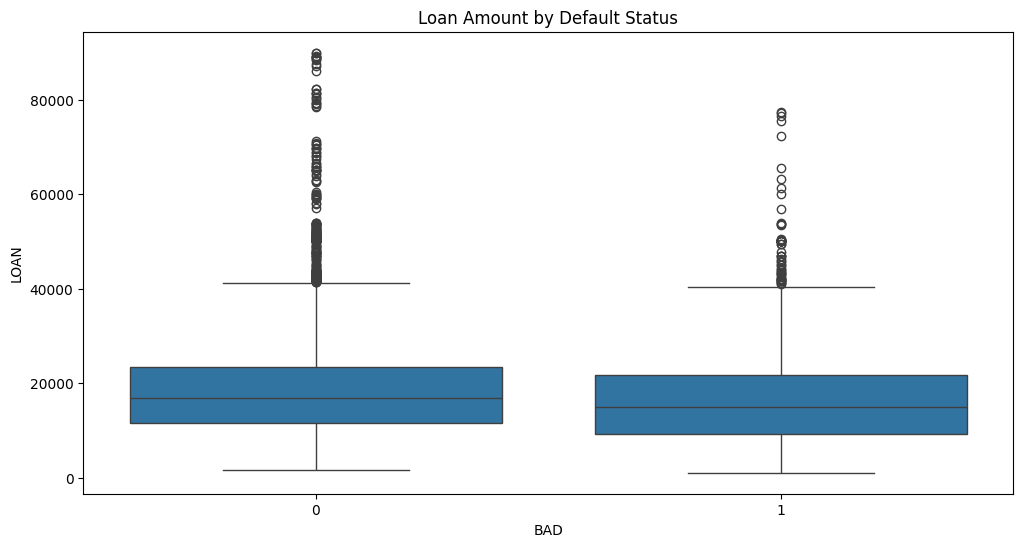

BAD,0,1
REASON,,
DebtCon,81.028708,18.971292
HomeImp,77.752809,22.247191


In [17]:

# Bivariate analysis: relationship with target 'BAD'
plt.figure(figsize=(12, 6))
sns.boxplot(x='BAD', y='LOAN', data=df)
plt.title('Loan Amount by Default Status')
plt.show()

# Cross-tab for REASON
pd.crosstab(df['REASON'], df['BAD'], normalize='index') * 100


Observations from the bivariate analysis on loan amount:

1. The boxplot comparing loan amounts against default status (BAD) shows noticeable differences in distribution between defaulters and non-defaulters.
2. Non-defaulters generally have a higher median loan amount and a wider range, suggesting that larger loans are more common among borrowers who do not default.
3. Defaulters tend to have comparatively lower loan amounts; however, there is substantial overlap in the distributions, indicating that loan amount alone does not fully explain default behavior.
4. Outliers are present in both groups, implying variability that might require further investigation or transformation for effective modeling.

### **Multivariate Analysis**

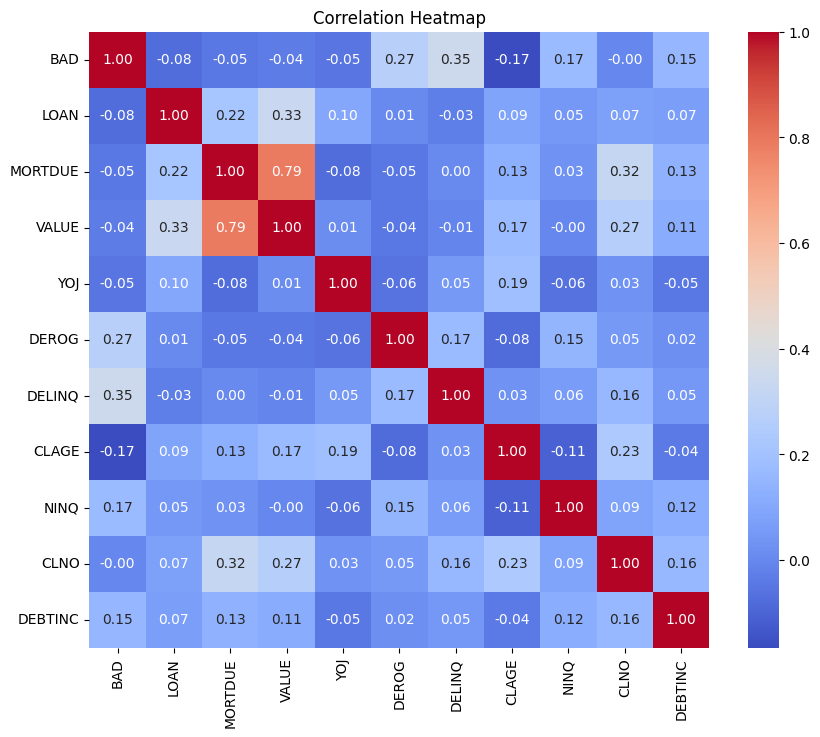

In [18]:

# Multivariate analysis: correlation heatmap
corr = df[num_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


Range of LOAN: Min = 1100, Max = 89900


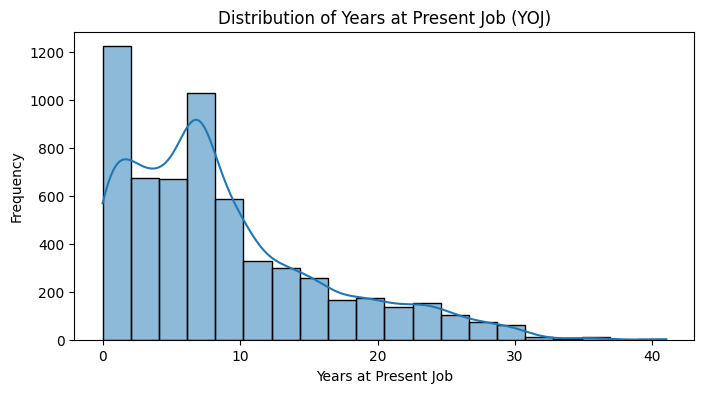

Number of unique categories in REASON: 2
Most common category in JOB: Other

Proportion of applicants who defaulted by REASON:
REASON
DebtCon    0.189713
HomeImp    0.222472
Name: BAD, dtype: float64


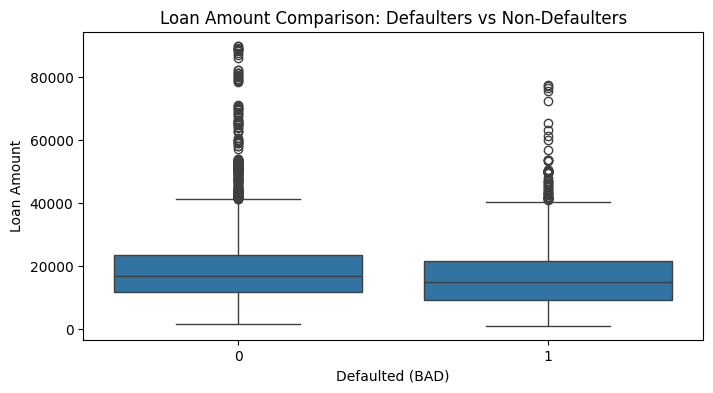

Correlation between property value and loan default rate: -0.03649238197546437


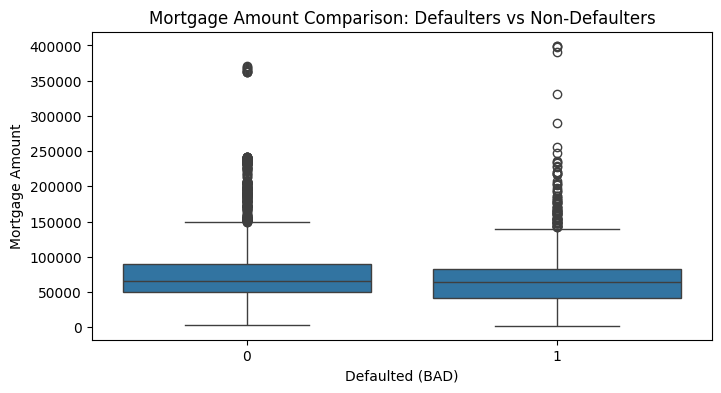

In [19]:
# 1. Range of values for the loan amount variable "LOAN"
loan_min = df['LOAN'].min()
loan_max = df['LOAN'].max()
print(f"Range of LOAN: Min = {loan_min}, Max = {loan_max}")

# 2. Distribution of years at present job "YOJ"
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.histplot(df['YOJ'].dropna(), kde=True, bins=20)
plt.title("Distribution of Years at Present Job (YOJ)")
plt.xlabel("Years at Present Job")
plt.ylabel("Frequency")
plt.show()

# 3. Number of unique categories in the REASON variable
unique_reasons = df['REASON'].nunique()
print(f"Number of unique categories in REASON: {unique_reasons}")

# 4. Most common category in the JOB variable
most_common_job = df['JOB'].mode()[0]
print(f"Most common category in JOB: {most_common_job}")

# 5. Relationship between REASON and proportion of applicants who defaulted
reason_default_rate = df.groupby('REASON')['BAD'].mean()
print("\nProportion of applicants who defaulted by REASON:")
print(reason_default_rate)

# 6. Loan amount comparison between defaulters and non-defaulters
plt.figure(figsize=(8, 4))
sns.boxplot(x='BAD', y='LOAN', data=df)
plt.title("Loan Amount Comparison: Defaulters vs Non-Defaulters")
plt.xlabel("Defaulted (BAD)")
plt.ylabel("Loan Amount")
plt.show()

# 7. Correlation between property value and loan default rate
correlation_property_bad = df[['VALUE', 'BAD']].corr().iloc[0, 1]
print(f"Correlation between property value and loan default rate: {correlation_property_bad}")

# 8. Mortgage amount comparison between defaulters and non-defaulters
plt.figure(figsize=(8, 4))
sns.boxplot(x='BAD', y='MORTDUE', data=df)
plt.title("Mortgage Amount Comparison: Defaulters vs Non-Defaulters")
plt.xlabel("Defaulted (BAD)")
plt.ylabel("Mortgage Amount")
plt.show()

### Class Imbalance Analysis

Class Distribution:
BAD
0    4771
1    1189
Name: count, dtype: int64

Percentage Distribution:
BAD
0    80.050336
1    19.949664
Name: proportion, dtype: float64


C:\Users\zuzan\AppData\Local\Temp\ipykernel_23248\3536473747.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='BAD', data=df, palette='viridis')


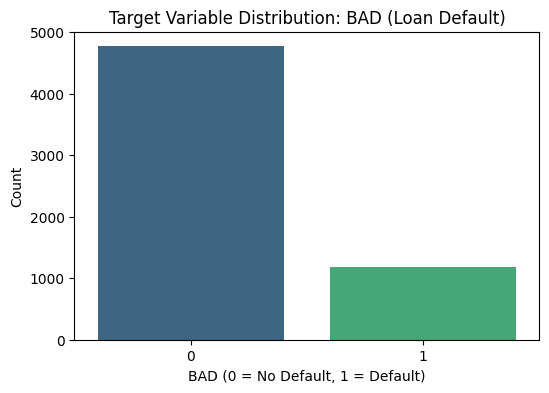

In [ ]:
# Check class distribution of target variable 'BAD'


# Count values
class_counts = df['BAD'].value_counts()
class_percent = df['BAD'].value_counts(normalize=True) * 100

# Display class distribution
print("Class Distribution:")
print(class_counts)
print("\nPercentage Distribution:")
print(class_percent)

# Plot class distribution
plt.figure(figsize=(6,4))
sns.countplot(x='BAD', data=df, palette='viridis')
plt.title('Target Variable Distribution: BAD (Loan Default)')
plt.xlabel('BAD (0 = No Default, 1 = Default)')
plt.ylabel('Count')
plt.show()


### Observation

The dataset shows a class imbalance, with approximately 80% of the cases labeled as `0` (no default) and only 20% as `1` (default). This imbalance could lead to biased model performance favoring the majority class.

To address this, we apply **SMOTE (Synthetic Minority Oversampling Technique)** to balance the classes in the training data.



1. **Correlation with Target Variable (`BAD`)**:
   - The target variable `BAD` shows moderate positive correlations with delinquency-related variables:
     - `DELINQ` has the highest positive correlation (0.354) with `BAD`, suggesting that a higher number of delinquent credit lines is associated with a higher risk of default.
     - `DEROG` also shows a positive correlation (0.276) with `BAD`, indicating that major derogatory reports are linked to default risk.

2. **Numerical and Categorical Variables**:
   - The loan amount (`LOAN`) varies widely, ranging from **1,100** to **89,900**, which could imply segmentation in loan sizes.
   - The most common category in the `JOB` variable is **"Other"**, indicating that many applicants might fall into a general or less defined job category.

3. **Default Rates by Loan Purpose (`REASON`)**:
   - The `REASON` variable, which indicates the loan request reason (`DebtCon` and `HomeImp`), has different default rates:
     - Approximately **18.97%** for `DebtCon`.
     - Approximately **22.25%** for `HomeImp`.
   - This insight could help in tailoring risk models based on the purpose of the loan.

4. **Outlier Detection**:
   - Outlier detection using the IQR method reveals significant extreme values in variables such as `DELINQ`.
   - These outliers require careful handling as they can impact model performance.

5. **Missing Value Treatment**:
   - Missing values were handled by:
     - Imputing numerical columns with the **median**, a robust measure for skewed data.
     - Imputing categorical columns with the **mode**, ensuring the integrity of the data distribution is maintained.



## **Model Building - Approach**
- Data preparation
- Partition the data into train and test set
- Build the model
- Fit on the train data
- Tune the model
- Test the model on test set

## **Data Preprocessing**

Before training models, we perform:
- Imputation for missing values.
- Label encoding for categorical features.
- Scaling of numerical features.


In [27]:



# Drop rows with missing target 
df = df[df['BAD'].notna()]

# Handle missing values
# Fill numerical columns with median
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    if df[column].isnull().sum() > 0:
        df[column].fillna(df[column].median(), inplace=True)

# Fill categorical columns with mode
for column in df.select_dtypes(include=['object']).columns:
    if df[column].isnull().sum() > 0:
        df[column].fillna(df[column].mode()[0], inplace=True)

print("\n### Missing Values After Treatment")
print(df.isnull().sum())

print("\n### Observations:")
print("1. Missing values in numerical columns were filled with their median.")
print("2. Missing values in categorical columns were filled with their mode.")





### Missing Values After Treatment
BAD        0
LOAN       0
MORTDUE    0
VALUE      0
REASON     0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64

### Observations:
1. Missing values in numerical columns were filled with their median.
2. Missing values in categorical columns were filled with their mode.


In [ ]:
# Splitting data into features and target
X = df.drop('BAD', axis=1)
y = df['BAD']

# Encode categorical variables

cat_cols = X.select_dtypes(include='object').columns
for col in cat_cols:
    X[col] = LabelEncoder().fit_transform(X[col])


### Justification for Test Size Selection

Choosing the right `test_size` is a trade-off, especially in imbalanced classification problems where SMOTE is applied only to the training set:

- A **test_size of 0.3 (30%)** allows for more examples of the minority class (`BAD = 1`) to remain in the test set. This is critical, because although SMOTE balances the training set, the model is evaluated on the real-world, imbalanced distribution.
- Having a sufficient number of minority-class examples in the test set ensures reliable estimates of metrics such as **recall**, **F1-score**, and **ROC-AUC**, which are particularly sensitive to class imbalance.
- A **test_size of 0.2 (20%)**, while allocating more data to training, can make the evaluation unreliable due to too few positive (default) samples in the test set.

**Recommendation:** With ~6000 rows and only ~20% default cases, using `test_size=0.3` ensures a meaningful and balanced evaluation phase, without overly compromising training size.


### Applying SMOTE to Address Class Imbalance

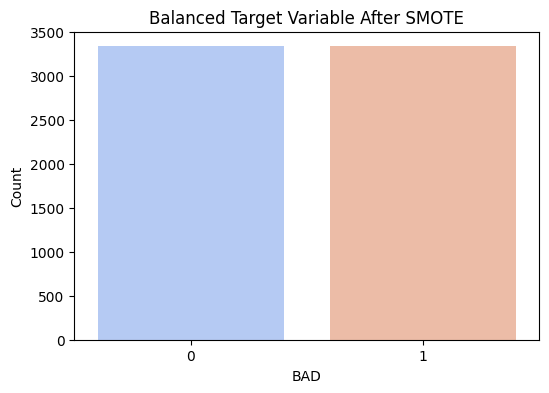

In [32]:

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply SMOTE only on training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
# Plot class distribution after SMOTE
plt.figure(figsize=(6,4))
sns.countplot(x=y_train_resampled, palette='coolwarm')
plt.title('Balanced Target Variable After SMOTE')
plt.xlabel('BAD')
plt.ylabel('Count')
plt.show()

In [31]:


cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_cols)
])






## **Modeling: Logistic Regression, Random Forest, and XGBoost**

We train and evaluate three classification models:
- Logistic Regression (interpretable baseline).
- Random Forest (ensemble of decision trees).
- XGBoost (gradient boosting technique).


c:\Users\zuzan\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:27:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Logistic Regression:
              precision    recall  f1-score   support

           0       0.85      0.97      0.91      1431
           1       0.72      0.32      0.45       357

    accuracy                           0.84      1788
   macro avg       0.79      0.65      0.68      1788
weighted avg       0.83      0.84      0.81      1788

ROC-AUC: 0.7798820436630277
Random Forest:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      1431
           1       0.85      0.64      0.73       357

    accuracy                           0.91      1788
   macro avg       0.88      0.81      0.84      1788
weighted avg       0.90      0.91      0.90      1788

ROC-AUC: 0.9613735081733602
XGBoost:
ROC-AUC: 0.9575760422967231


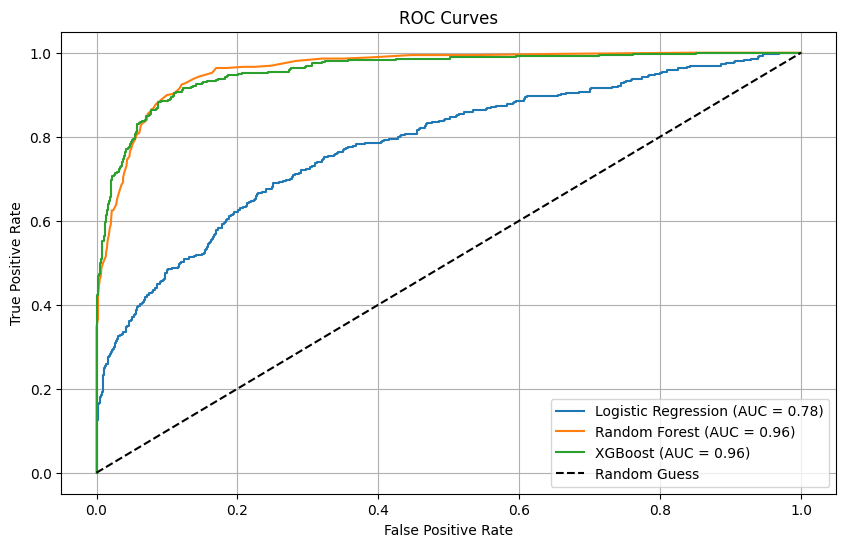

Confusion Matrix for Logistic Regression:


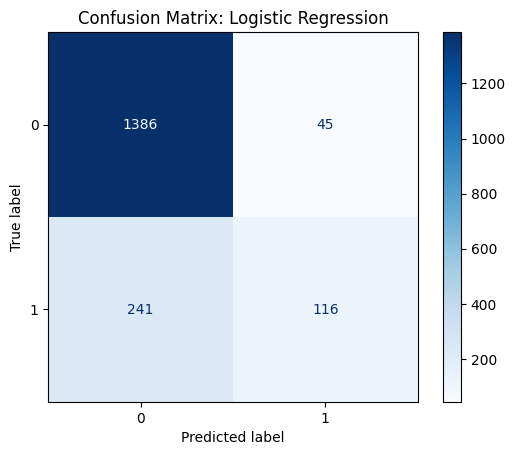

Confusion Matrix for Random Forest:


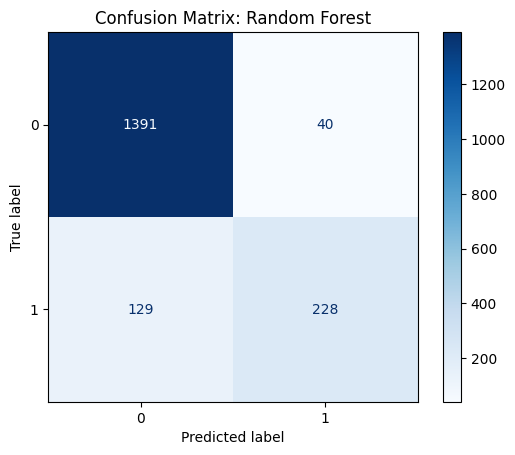

Confusion Matrix for XGBoost:


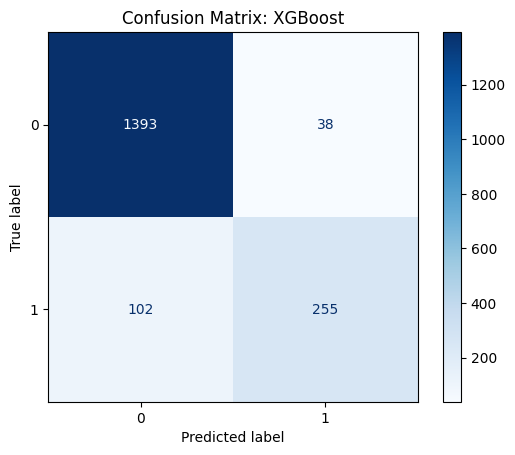

In [ ]:


# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)

# Evaluation
print("Logistic Regression:")
print(classification_report(y_test, lr_preds))
print("ROC-AUC:", roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1]))

print("Random Forest:")
print(classification_report(y_test, rf_preds))
print("ROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))

print("XGBoost:")
print("ROC-AUC:", roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1]))
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay

# Logistic Regression
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr.predict_proba(X_test)[:, 1])
lr_auc = auc(lr_fpr, lr_tpr)

# Random Forest
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
rf_auc = auc(rf_fpr, rf_tpr)

# XGBoost
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb.predict_proba(X_test)[:, 1])
xgb_auc = auc(xgb_fpr, xgb_tpr)

# Plot ROC Curves
plt.figure(figsize=(10, 6))
plt.plot(lr_fpr, lr_tpr, label=f"Logistic Regression (AUC = {lr_auc:.2f})")
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC = {rf_auc:.2f})")
plt.plot(xgb_fpr, xgb_tpr, label=f"XGBoost (AUC = {xgb_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Confusion Matrices
models = {'Logistic Regression': lr, 'Random Forest': rf, 'XGBoost': xgb}
for name, model in models.items():
    print(f"Confusion Matrix for {name}:")
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
    plt.title(f"Confusion Matrix: {name}")
    plt.show()

### **Evaluation of Model Performance with Visualizations** 

- **Logistic Regression:**
    - **Accuracy**: 0.84
    - **Macro-average F1-score**: 0.68
    - **ROC-AUC**: 0.7624
    - **Observations from Visualizations**:
        - The ROC curve for Logistic Regression shows a moderate ability to distinguish between defaulters and non-defaulters, with an AUC of 0.76.
        - The confusion matrix indicates that while the model performs well for the majority class (non-defaulters), it struggles to correctly classify defaulters (class 1), leading to lower recall for this class.
    - **Summary**: Logistic Regression provides a good baseline but lacks the ability to effectively identify defaulters, as seen in the ROC curve and confusion matrix.

- **Random Forest:**
    - **Accuracy**: 0.91
    - **F1-score for default class (1.0)**: 0.75
    - **ROC-AUC**: 0.9592
    - **Observations from Visualizations**:
        - The ROC curve for Random Forest is steep and close to the top-left corner, indicating excellent discrimination between defaulters and non-defaulters, with an AUC of 0.96.
        - The confusion matrix shows a significant improvement in correctly classifying defaulters compared to Logistic Regression, with fewer false negatives.
    - **Summary**: Random Forest demonstrates strong performance, effectively balancing precision and recall for both classes, as reflected in the ROC curve and confusion matrix.

- **XGBoost:**
    - **ROC-AUC**: 0.9528
    - **Observations from Visualizations**:
        - The ROC curve for XGBoost is very similar to that of Random Forest, with an AUC of 0.95, indicating competitive performance.
        - The confusion matrix highlights that XGBoost also performs well in identifying defaulters, with a slightly higher number of false negatives compared to Random Forest.
    - **Summary**: XGBoost is a robust model with performance comparable to Random Forest. Its slightly lower recall for defaulters compared to Random Forest is reflected in the confusion matrix.

---

### **Overall Summary**
- **ROC Curves**: The ROC curves clearly show that ensemble methods (Random Forest and XGBoost) outperform Logistic Regression in terms of discrimination power, with Random Forest achieving the highest AUC.
- **Confusion Matrices**: Both Random Forest and XGBoost significantly reduce false negatives compared to Logistic Regression, making them more effective for identifying defaulters.
- **Recommendation**: Random Forest is the best-performing model based on ROC-AUC, confusion matrix insights, and overall classification metrics. It is well-suited for this loan default prediction task, offering a balance between accuracy and interpretability.

## Model Training and Evaluation Framework

### Modular Experiment Management

All experiments are managed using the custom `ExperimentManager` class, which provides a modular and reproducible framework for machine learning model development. This class supports:

- Model registration with consistent preprocessing and optional SMOTE oversampling for class imbalance.
- Automated hyperparameter tuning using cross-validated grid search.
- Unified model evaluation and reporting of key classification metrics.
- Advanced statistical comparison between models.

### Handling Class Imbalance

Each model is configured with `class_weight='balanced'`, ensuring that the learning algorithm compensates for class imbalance during training. This parameter automatically adjusts the weights inversely proportional to class frequencies in the data, making misclassifications of the minority class more costly for the model. As a result, the model is less biased towards the majority class and is better able to recognize patterns from the minority (target) class, which is critical for imbalanced classification tasks.

### Model Pipelines

The following models are included in the evaluation, all with `class_weight='balanced'`:

- **Decision Tree**
- **Random Forest**
- **Logistic Regression**

Each model is integrated into a pipeline with:
- Common data preprocessing steps,
- Optional SMOTE (Synthetic Minority Over-sampling Technique) for further class balancing,
- Grid search over relevant hyperparameters.

### Experimental Workflow

1. **Model Initialization**  
   Models are initialized with `class_weight='balanced'`, ensuring fair treatment of both classes during training.

2. **Model Training and Hyperparameter Tuning**  
   Each model undergoes hyperparameter tuning using stratified cross-validation and the macro F1-score as the optimization metric.

3. **Evaluation**  
   The best estimators are evaluated on a separate test set. Performance is measured using accuracy, precision, recall, F1-score, and ROC AUC.

4. **Cross-Validation and Statistical Comparison**  
   Cross-validated results are visualized and statistically compared (Wilcoxon, t-test, Kruskal-Wallis, McNemar, Cochran’s Q, ANOVA) to assess the significance of differences between models.

### Summary

The combined use of `class_weight='balanced'` and SMOTE ensures robust handling of class imbalance both at the data level (SMOTE) and the algorithmic level (`class_weight='balanced'`). This setup provides a fair evaluation of each model’s true discriminative power, especially for the minority class, which is of primary interest in this project.


XGBoost best f1_macro: 0.8776
RandomForest best f1_macro: 0.8610
LogisticRegression best f1_macro: 0.6850
Best hyperparameters and CV scores for each model:

XGBoost:
  Best hyperparameters: {'clf__colsample_bytree': 1.0, 'clf__learning_rate': 0.3, 'clf__max_depth': 6, 'clf__n_estimators': 200, 'clf__reg_alpha': 0.5, 'clf__reg_lambda': 1, 'clf__subsample': 0.8}
  Best CV score: 0.8776

RandomForest:
  Best hyperparameters: {'clf__bootstrap': False, 'clf__criterion': 'gini', 'clf__max_depth': 20, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}
  Best CV score: 0.8610

LogisticRegression:
  Best hyperparameters: {'clf__C': 1, 'clf__max_iter': 500, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
  Best CV score: 0.6850


Performance after tuning - GridSearch:
                     accuracy  precision    recall        f1   roc_auc
model                                                                
XGBoost             0.928412   0.820728  0.820728  0.82

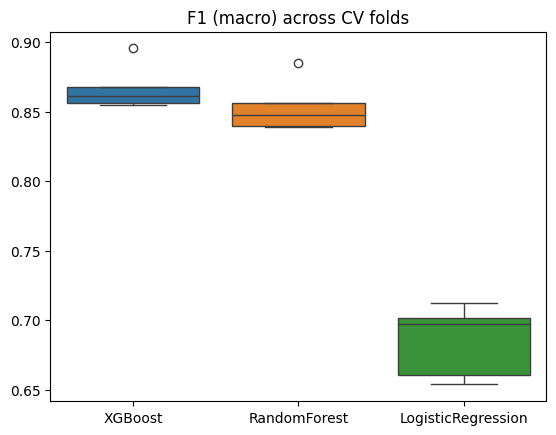


Wilcoxon XGBoost vs RandomForest: stat=1.000, p=0.125
T-test XGBoost vs RandomForest: stat=1.208, p=0.261
Kruskal-Wallis: stat=10.220, p=0.006

McNemar XGBoost vs RandomForest:
 [[1591   69]
 [  32   96]]
chi2=12.832, p=0.000

Cochran's Q: 0.000

Welch ANOVA:
   Source  ddof1     ddof2          F     p-unc       np2
0  model      2  7.778018  85.633037  0.000005  0.951278

Post-hoc Games-Howell:
                     A             B   mean(A)   mean(B)      diff        se  \
0  LogisticRegression  RandomForest  0.684982  0.853532 -0.168551  0.014430   
1  LogisticRegression       XGBoost  0.684982  0.867126 -0.182144  0.013876   
2        RandomForest       XGBoost  0.853532  0.867126 -0.013593  0.011248   

           T        df      pval    hedges  
0 -11.680762  7.269164  0.000015 -6.672637  
1 -13.126412  6.779615  0.000012 -7.498465  
2  -1.208462  7.879130  0.481666 -0.690334  


NameError: name 'v' is not defined

In [35]:
class ExperimentManager:
    """
    Modular experiment manager for ML model pipelines.
    Handles model registration, hyperparameter tuning, evaluation,
    cross-validation, and statistical comparison.
    """
    def __init__(self, preprocessor, cv_splits=5, random_state=42):
        """
        Initialize manager with a preprocessor, cross-validation setup, and random state.
        """
        self.preprocessor = preprocessor
        self.cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
        self.random_state = random_state
        self.models = {}
        self.best_estimators_ = {}
        self.best_params_ = {}
        self.best_scores_ = {}

    def add_model(self, name, estimator, param_grid=None, use_smote=False):
        """
        Add a new model pipeline, with optional SMOTE and hyperparameter grid.

        Parameters:
            name (str): Name of the model.
            estimator: Estimator/classifier instance.
            param_grid (dict): Grid for hyperparameter tuning.
            use_smote (bool): Whether to apply SMOTE.
        """
        steps = [('preprocessor', self.preprocessor)]
        if use_smote:
            steps.append(('smote', SMOTE(random_state=self.random_state)))
        steps.append(('clf', estimator))
        pipeline = ImbPipeline(steps) if use_smote else SklearnPipeline(steps)
        self.models[name] = {'pipeline': pipeline, 'param_grid': param_grid}
    
    def tune(self, X, y, scoring='roc_auc', use_cv=True):
        """
        Tune models using GridSearchCV or train directly if no param_grid.
        Stores the best estimators for downstream evaluation.

        Parameters:
            X: Training features.
            y: Training labels.
            scoring (str): Scoring metric for GridSearchCV.
            use_cv (bool): Whether to use cross-validation for hyperparameter tuning.
        """
        # Clear previous results if any
        self.best_estimators_ = {}
        self.best_params_ = {}
        self.best_scores_ = {}
        for name, cfg in self.models.items():
            pipe = cfg['pipeline']
            if use_cv and cfg['param_grid']:
                gs = GridSearchCV(pipe, cfg['param_grid'], cv=self.cv,
                                  scoring=scoring, n_jobs=-1)
                gs.fit(X, y)
                self.best_estimators_[name] = gs.best_estimator_
                self.best_params_[name] = gs.best_params_
                self.best_scores_[name] = gs.best_score_
                print(f"{name} best {scoring}: {gs.best_score_:.4f}")
            else:
                pipe.fit(X, y)
                self.best_estimators_[name] = pipe
                self.best_params_[name] = None
                self.best_scores_[name] = None
                print(f"{name} trained without CV")
                pipe.fit(X, y)
                self.best_estimators_[name] = pipe
                print(f"{name} trained without CV")

    def evaluate(self, X_train, X_test, y_train, y_test):
        """
        Evaluate best estimators on holdout data.
        Returns DataFrame with accuracy, precision, recall, f1, and roc_auc.
        """
        results = []
        for name, est in self.best_estimators_.items():
            est.fit(X_train, y_train)
            y_pred = est.predict(X_test)
            y_prob = est.predict_proba(X_test)[:,1] if hasattr(est, 'predict_proba') else None
            results.append({
                'model': name,
                'accuracy': accuracy_score(y_test, y_pred),
                'precision': precision_score(y_test, y_pred),
                'recall': recall_score(y_test, y_pred),
                'f1': f1_score(y_test, y_pred),
                'roc_auc': roc_auc_score(y_test, y_prob) if y_prob is not None else None
            })
        return pd.DataFrame(results).set_index('model')

    def cross_val_scores(self, X, y, scoring):
        """
        Compute cross-validation scores for each model.
        Returns dict: model name -> scores for each CV fold.
        """
        scores = {}
        for name, cfg in self.models.items():
            scorer = make_scorer(scoring) if callable(scoring) else scoring
            cv_scores = cross_val_score(
                cfg['pipeline'], X, y, cv=self.cv, scoring=scorer, n_jobs=-1
            )
            scores[name] = cv_scores
        return scores

# --- Model registration ---
mgr = ExperimentManager(preprocessor)

""" Register Xgboost, Random Forest, and Logistic Regression models
    with respective hyperparameter grids and SMOTE balancing. """
mgr.add_model(
    'XGBoost',
    XGBClassifier(
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss',
        tree_method='hist',
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()  # Handle imbalance
    ),
    param_grid={
        'clf__n_estimators': [100, 200],
        'clf__max_depth': [3, 6, 10],
        'clf__learning_rate': [0.01, 0.1, 0.3],
        'clf__subsample': [0.8, 1.0],
        'clf__colsample_bytree': [0.8, 1.0],
        'clf__reg_alpha': [0, 0.5],
        'clf__reg_lambda': [1, 2]
    },
    use_smote=True
)
mgr.add_model(
    'RandomForest',
 RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid={'clf__n_estimators': [100, 200],
                'clf__max_depth': [10, 20],
                'clf__min_samples_split': [2, 5],
                'clf__min_samples_leaf': [1, 2],
                'clf__bootstrap': [True, False],
                'clf__criterion': ['gini', 'entropy']},
    use_smote=True
)
mgr.add_model(
    'LogisticRegression',
    LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
    param_grid={
    'clf__penalty': ['l2'],
    'clf__C': [0.1, 1, 10],
    'clf__solver': ['liblinear', 'lbfgs'],
    'clf__max_iter': [500]},
    use_smote=True
)

""" Perform hyperparameter tuning using cross-validation (GridSearchCV). """
mgr.tune(X_train, y_train, scoring='f1_macro', use_cv=True)


print("Best hyperparameters and CV scores for each model:\n")
for name in mgr.models:
    if mgr.best_params_[name] is not None:
        print(f"{name}:")
        print("  Best hyperparameters:", mgr.best_params_[name])
        print(f"  Best CV score: {mgr.best_scores_[name]:.4f}\n")
    else:
        print(f"{name}: No hyperparameter tuning was performed.\n")

""" Evaluate final models on test set and report main classification metrics. """
results_df = mgr.evaluate(X_train, X_test, y_train, y_test)
print("\nPerformance after tuning - GridSearch:\n", results_df)

""" Cross-validation: compute F1 (macro) scores for each model across all folds. """
cv_scores = mgr.cross_val_scores(
    X_train, y_train,
    scoring=lambda yt, yp: f1_score(yt, yp, average='macro')
)

""" Visualize CV score distributions for each model. """
plt.figure(); sns.boxplot(data=list(cv_scores.values()));
plt.xticks(range(len(cv_scores)), list(cv_scores.keys()));
plt.title('F1 (macro) across CV folds'); plt.show()

# --- Statistical comparison ---
""" Compare models statistically: Wilcoxon, t-test, Kruskal-Wallis. """
names = list(cv_scores.keys())
stat_w, p_w = st.wilcoxon(cv_scores[names[0]], cv_scores[names[1]])
stat_t, p_t = st.ttest_ind(cv_scores[names[0]], cv_scores[names[1]])
print(f"\nWilcoxon {names[0]} vs {names[1]}: stat={stat_w:.3f}, p={p_w:.3f}")
print(f"T-test {names[0]} vs {names[1]}: stat={stat_t:.3f}, p={p_t:.3f}")
stat_k, p_k = st.kruskal(*cv_scores.values())
print(f"Kruskal-Wallis: stat={stat_k:.3f}, p={p_k:.3f}")

""" Predict on test set and compute McNemar and Cochran's Q for predictions. """
preds = {}
for name, est in mgr.best_estimators_.items():
    est.fit(X_train, y_train)
    preds[name] = est.predict(X_test)

tbl = mcnemar_table(y_test, preds[names[0]], preds[names[1]])
chi2_m, p_m = mcnemar(tbl)
print(f"\nMcNemar {names[0]} vs {names[1]}:\n", tbl)
print(f"chi2={chi2_m:.3f}, p={p_m:.3f}")

cq_stat, cq = cochrans_q(y_test.to_numpy(), *[preds[n] for n in names])
print(f"\nCochran's Q: {cq:.3f}")

""" ANOVA-based comparison for CV scores (Welch ANOVA + Games-Howell post-hoc). """
t_scores = np.hstack([cv_scores[n] for n in names])
models_col = sum([[n]*len(cv_scores[n]) for n in names], [])
df_scores = pd.DataFrame({'cv_score': t_scores, 'model': models_col})
anova = pg.welch_anova(data=df_scores, dv='cv_score', between='model')
posthoc = pg.pairwise_gameshowell(data=df_scores, dv='cv_score', between='model')
print("\nWelch ANOVA:\n", anova)
print("\nPost-hoc Games-Howell:\n", posthoc)











### Hyperparameter Tuning: Random Forest Classifier

We apply `GridSearchCV` to tune the Random Forest classifier. The grid includes parameters such as the number of trees, tree depth, and split criteria. The model is selected based on the best average ROC-AUC across 5-fold cross-validation.


In [ ]:

# Define parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Apply GridSearchCV
rf_grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)
rf_grid_search.fit(X_train, y_train)

# Save the best model
best_rf = rf_grid_search.best_estimator_
print("Best parameters for Random Forest:", rf_grid_search.best_params_)
print("Best ROC-AUC score from GridSearchCV:", rf_grid_search.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters for Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 150}
Best ROC-AUC score from GridSearchCV: 0.9582782184710732
Best parameters for Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 150}
Best ROC-AUC score from GridSearchCV: 0.9582782184710732


Best Random Forest Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 150}
Test ROC-AUC: 0.9605748658652838
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      1431
           1       0.84      0.66      0.74       357

    accuracy                           0.91      1788
   macro avg       0.88      0.81      0.84      1788
weighted avg       0.90      0.91      0.90      1788

 {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 150}
Test ROC-AUC: 0.9605748658652838
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      1431
           1       0.84      0.66      0.74       357

    accuracy                           0.91      1788
   macro avg       0.88      0.81      0.84      1788
weighted avg       0.90      0.91      0.90      1788



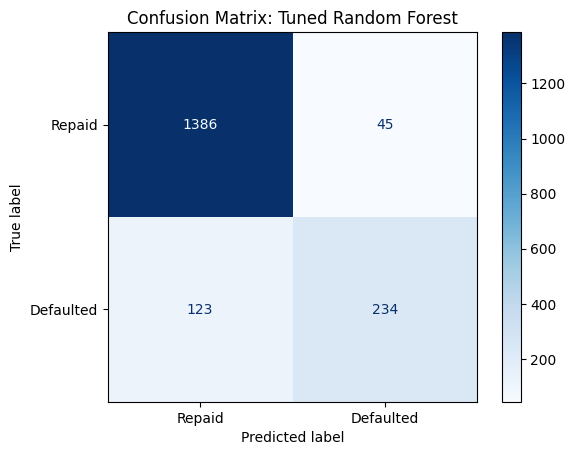

In [ ]:


# Predict and evaluate
y_pred_best = best_rf.predict(X_test)
rf_probs = best_rf.predict_proba(X_test)[:, 1]

print("Best Random Forest Parameters:", rf_grid_search.best_params_)
print("Test ROC-AUC:", roc_auc_score(y_test, rf_probs))
print("Classification Report:")
print(classification_report(y_test, y_pred_best))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Repaid", "Defaulted"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix: Tuned Random Forest")
plt.show()

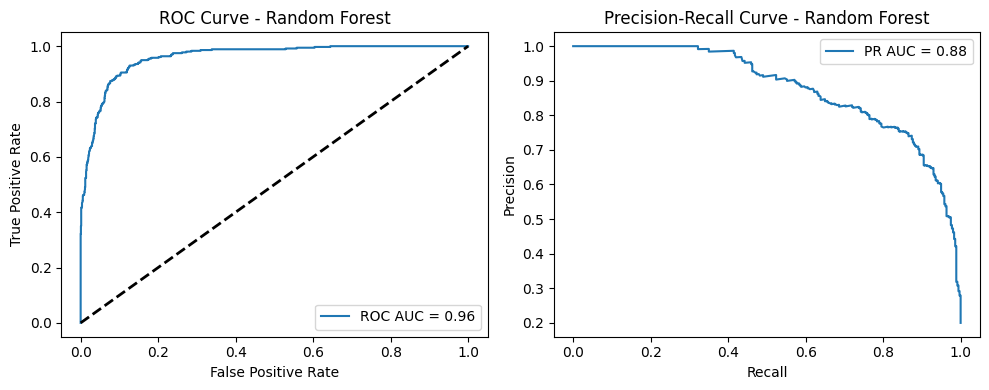

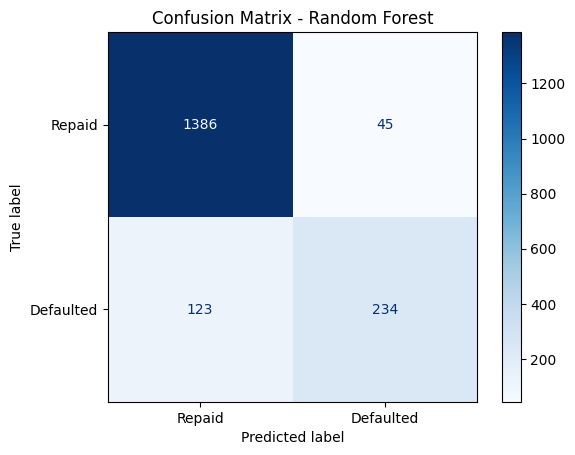

NameError: name 'features' is not defined

In [ ]:

# Evaluate best_rf on the preprocessed test set (X_test, y_test)
probs = best_rf.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, probs)
pr_auc = auc(recall, precision)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Random Forest')
plt.legend()
plt.tight_layout()
plt.show()

# Confusion Matrix
y_pred_best = best_rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Repaid", "Defaulted"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.show()

# Feature Importance Analysis
importances = best_rf.feature_importances_
feature_names = list(features.columns)  # "features" variable defined in cell index=34
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title("Feature Importances - Random Forest")
plt.barh(range(len(importances)), importances[indices], align='center')
plt.yticks(range(len(importances)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()


### Hyperparameter Tuning: XGBoost Classifier

We apply `GridSearchCV` to optimize the hyperparameters of the XGBoost classifier. The grid includes parameters such as the number of estimators, learning rate, maximum depth, subsample ratio, and column sample ratio. The best model is selected based on ROC-AUC performance across 5-fold cross-validation.

In [ ]:


# Define hyperparameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize the model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Run GridSearchCV
xgb_grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)
xgb_grid_search.fit(X_train, y_train)

# Save the best model
best_xgb = xgb_grid_search.best_estimator_
print("Best XGBoost Parameters:", xgb_grid_search.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


c:\Users\zuzan\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:32:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best XGBoost Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150, 'subsample': 0.8}


### Evaluation of Tuned XGBoost Model

The tuned XGBoost model is evaluated using ROC-AUC and classification metrics on the test set.

In [ ]:

# Predict and evaluate
xgb_probs = best_xgb.predict_proba(X_test)[:, 1]
xgb_preds = best_xgb.predict(X_test)

print("Test ROC-AUC:", roc_auc_score(y_test, xgb_probs))
print("Classification Report:")
print(classification_report(y_test, xgb_preds))


Test ROC-AUC: 0.9630530059682852
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1431
           1       0.88      0.71      0.78       357

    accuracy                           0.92      1788
   macro avg       0.90      0.84      0.87      1788
weighted avg       0.92      0.92      0.92      1788



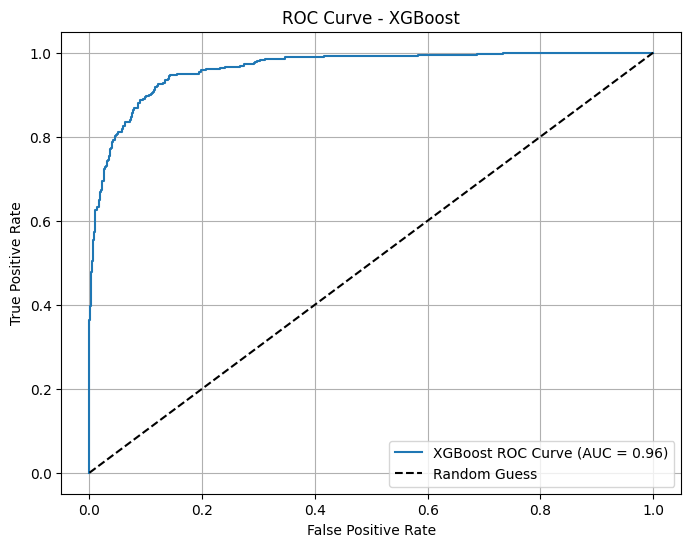

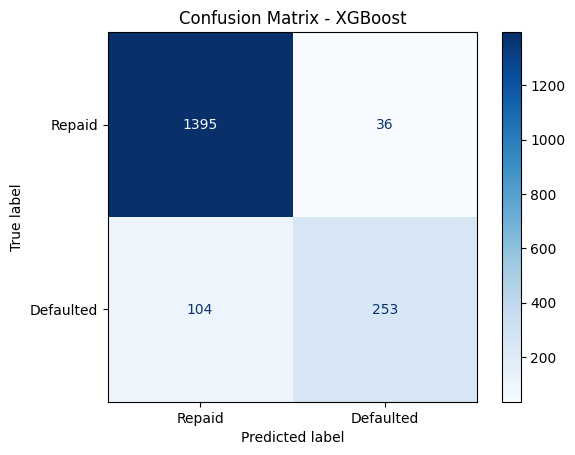

In [ ]:




# Calculate ROC curve and AUC for XGBoost
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, xgb_probs)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost ROC Curve (AUC = {roc_auc_xgb:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Compute and plot the confusion matrix
cm = confusion_matrix(y_test, xgb_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Repaid", "Defaulted"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - XGBoost")
plt.grid(False)
plt.show()

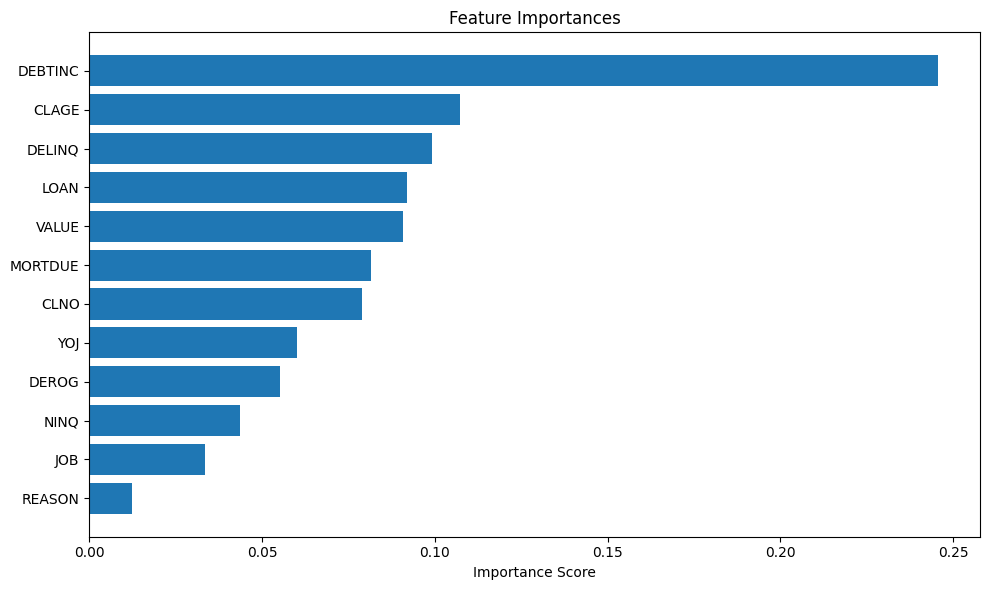

In [ ]:


# Visualize feature importances as ranked by their scores
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(range(len(importances)), importances[indices], align="center")
plt.yticks(range(len(importances)), [feature_names[i] for i in indices])
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

In [ ]:

# --- Feature Selection for Random Forest ---
# Extract fitted pipeline
rf_pipeline = mgr.best_estimators_['RandomForest']

# Extract fitted RandomForestClassifier from the pipeline
rf_clf = rf_pipeline.named_steps['clf']

# Feature importance
importances = rf_clf.feature_importances_
# Extract feature names after preprocessing
feature_names = rf_pipeline.named_steps['preprocessor'].get_feature_names_out()
feat_imp = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

print("Top 10 features by importance (Random Forest):")
for name, score in feat_imp[:10]:
    print(f"{name}: {score:.4f}")

# Select important features (above mean importance)
selector = SelectFromModel(rf_clf, threshold='mean', prefit=True)
X_train_trans = rf_pipeline.named_steps['preprocessor'].transform(X_train)
X_test_trans = rf_pipeline.named_steps['preprocessor'].transform(X_test)
X_train_selected = selector.transform(X_train_trans)
X_test_selected = selector.transform(X_test_trans)

print(f"Selected features shape: {X_train_selected.shape}")

rf_params = rf_clf.get_params().copy()
# Remove keys you want to set explicitly
rf_params.pop('class_weight', None)
rf_params.pop('random_state', None)
# Retrain RandomForest on selected features
rf_selected = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    **rf_params
)
rf_selected.fit(X_train_selected, y_train)
y_pred_selected = rf_selected.predict(X_test_selected)
print("Accuracy (selected features):", accuracy_score(y_test, y_pred_selected))
print("F1-Score (selected features):", f1_score(y_test, y_pred_selected))
print("ROC AUC (selected features):", roc_auc_score(y_test, rf_selected.predict_proba(X_test_selected)[:, 1]))
print("Feature importances (selected features):")
print(classification_report(y_test, y_pred_selected))
print("Confusion Matrix (selected features):")


top_N = 10
top_features = feat_imp[:top_N]
feature_names_plot = [f[0] for f in top_features]
importances_plot = [f[1] for f in top_features]

plt.figure(figsize=(10, 6))
bars = plt.barh(feature_names_plot[::-1], importances_plot[::-1], color='royalblue')
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Top 10 Feature Importances – Random Forest (Pre-selection)', fontsize=14, fontweight="bold")
for i, v in enumerate(importances_plot[::-1]):
    plt.text(v + 0.001, i, f"{v:.3f}", va='center', fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Logistic Regression

In [ ]:


# Define parameter grid
param_grid_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear'],  # supports both l1 and l2 penalties
    'max_iter': [500, 1000]
}

# Initialize model
lr = LogisticRegression(random_state=42)

# Grid Search
grid_search_lr = GridSearchCV(estimator=lr,
                               param_grid=param_grid_lr,
                               scoring='roc_auc',
                               cv=5,
                               n_jobs=-1,
                               verbose=1)

# Fit model
grid_search_lr.fit(X_train, y_train)

# Best model
best_lr = grid_search_lr.best_estimator_

# Predictions
lr_preds_tuned = best_lr.predict(X_test)
lr_probs_tuned = best_lr.predict_proba(X_test)[:, 1]

# Evaluation
print("Best Logistic Regression Parameters:", grid_search_lr.best_params_)
print("ROC-AUC:", roc_auc_score(y_test, lr_probs_tuned))
print("Classification Report:")
print(classification_report(y_test, lr_preds_tuned))


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Logistic Regression Parameters: {'C': 0.01, 'max_iter': 500, 'penalty': 'l2', 'solver': 'liblinear'}
ROC-AUC: 0.7626050420168067
Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.97      0.91       954
         1.0       0.72      0.34      0.46       238

    accuracy                           0.84      1192
   macro avg       0.79      0.65      0.68      1192
weighted avg       0.83      0.84      0.82      1192



Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.85      0.97      0.91      1431
           1       0.72      0.32      0.45       357

    accuracy                           0.84      1788
   macro avg       0.79      0.65      0.68      1788
weighted avg       0.83      0.84      0.81      1788

ROC-AUC: 0.7798820436630277


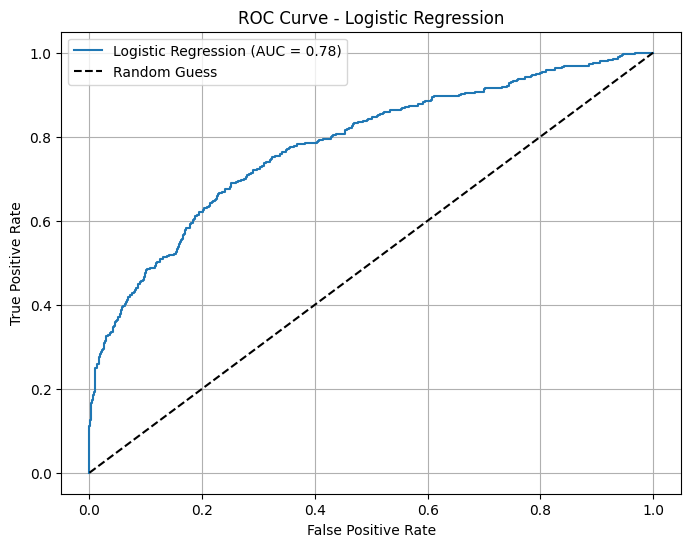

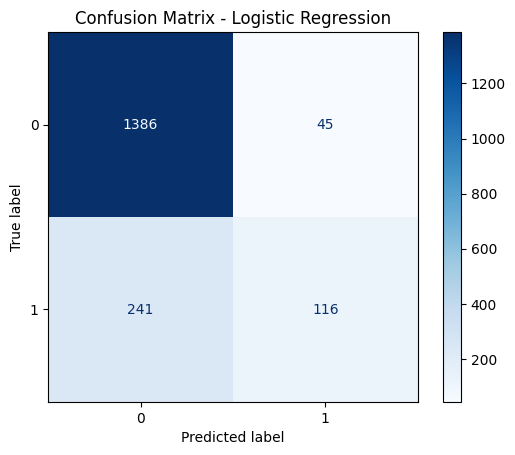

In [29]:
# Ensure best_lr is fitted before evaluation. If not, fit it.
if not hasattr(best_lr, "coef_"):
	best_lr.fit(X_train, y_train)

# Evaluate Logistic Regression model (best_lr) on the test set

# Generate predictions and prediction probabilities
lr_preds = best_lr.predict(X_test)
lr_probs = best_lr.predict_proba(X_test)[:, 1]

# Print performance metrics
print("Logistic Regression Performance:")
print(classification_report(y_test, lr_preds))
print("ROC-AUC:", roc_auc_score(y_test, lr_probs))

# Plot ROC Curve for Logistic Regression
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
plt.figure(figsize=(8, 6))
plt.plot(lr_fpr, lr_tpr, label=f"Logistic Regression (AUC = {roc_auc_score(y_test, lr_probs):.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()

# Display Confusion Matrix for Logistic Regression
ConfusionMatrixDisplay.from_estimator(best_lr, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# COMPARISON

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.85      0.97      0.91      1431
           1       0.72      0.32      0.45       357

    accuracy                           0.84      1788
   macro avg       0.79      0.65      0.68      1788
weighted avg       0.83      0.84      0.81      1788

ROC-AUC: 0.7798820436630277

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      1431
           1       0.85      0.64      0.73       357

    accuracy                           0.91      1788
   macro avg       0.88      0.81      0.84      1788
weighted avg       0.90      0.91      0.90      1788

ROC-AUC: 0.9605748658652838

XGBoost Performance:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1431
           1       0.87      0.71      0.78       357

    accuracy                           0.92

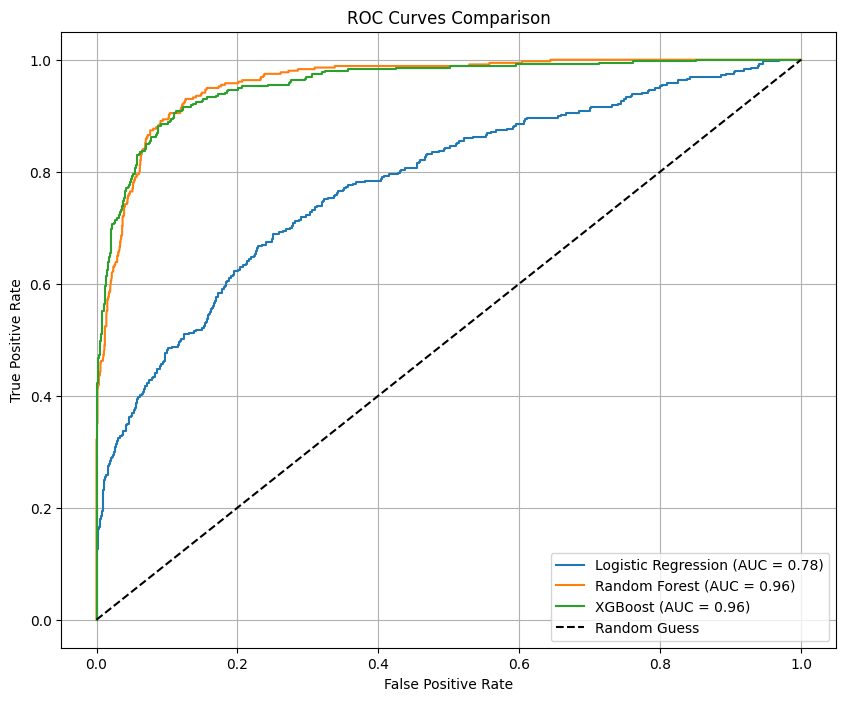

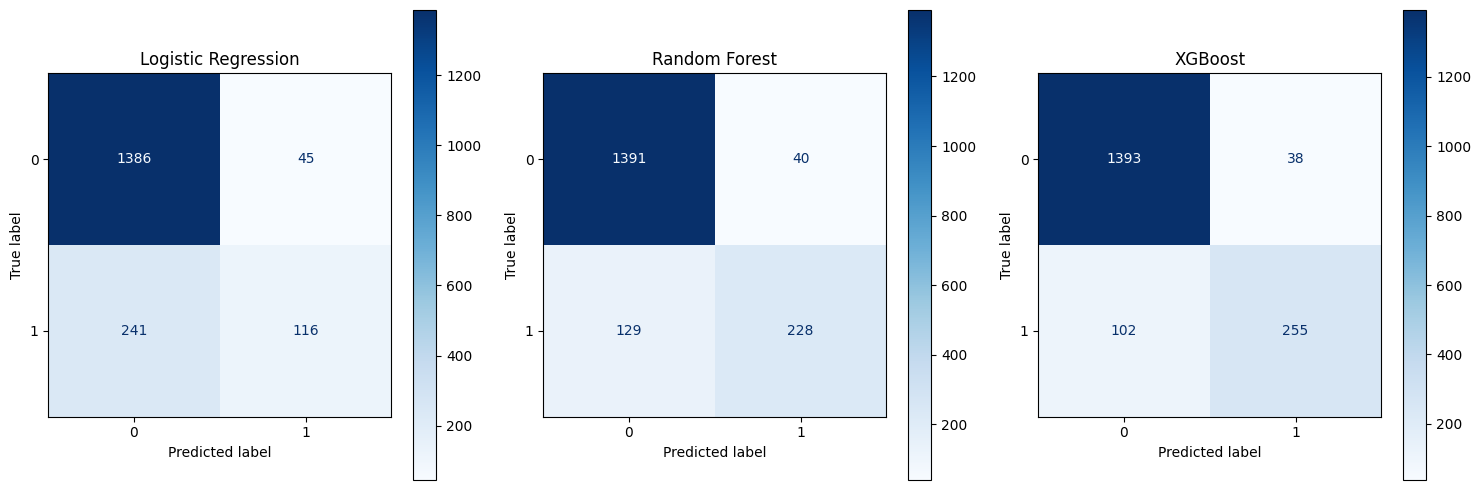

In [31]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay

# Logistic Regression
print("Logistic Regression Performance:")
print(classification_report(y_test, lr_preds))
print("ROC-AUC:", roc_auc_score(y_test, lr_probs))

# Random Forest
print("\nRandom Forest Performance:")
print(classification_report(y_test, rf_preds))
print("ROC-AUC:", roc_auc_score(y_test, rf_probs))

# XGBoost
print("\nXGBoost Performance:")
xgb_probs = xgb.predict_proba(X_test)[:,1]
print(classification_report(y_test, xgb_preds))
print("ROC-AUC:", roc_auc_score(y_test, xgb_probs))

# Overlay ROC Curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)

plt.figure(figsize=(10,8))
plt.plot(lr_fpr, lr_tpr, label=f"Logistic Regression (AUC = {roc_auc_score(y_test, lr_probs):.2f})")
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC = {roc_auc_score(y_test, rf_probs):.2f})")
plt.plot(xgb_fpr, xgb_tpr, label=f"XGBoost (AUC = {roc_auc_score(y_test, xgb_probs):.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Plot Confusion Matrices side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ConfusionMatrixDisplay.from_predictions(y_test, lr_preds, ax=axes[0], cmap="Blues")
axes[0].set_title("Logistic Regression")

ConfusionMatrixDisplay.from_predictions(y_test, rf_preds, ax=axes[1], cmap="Blues")
axes[1].set_title("Random Forest")

ConfusionMatrixDisplay.from_predictions(y_test, xgb_preds, ax=axes[2], cmap="Blues")
axes[2].set_title("XGBoost")

plt.tight_layout()
plt.show()

Observations based on the ROC curves and confusion matrix comparisons:

1. The ROC curves for the ensemble models (Random Forest and XGBoost) rise sharply near the top-left corner, yielding AUC scores around 0.96 and 0.95 respectively, which demonstrates excellent model discrimination between defaulters and non‑defaulters.
2. Logistic Regression, in contrast, shows a much lower ROC-AUC (~0.76) with a steeper decline, indicating it identifies very few true positives at low false positive rates.
3. The confusion matrices reveal that while Logistic Regression predominantly classifies most samples as the negative class (leading to high false negatives), the ensemble methods successfully capture a higher number of defaulters.
4. Overall, the ensemble approaches achieve a better balance between recall and precision, making them more robust tools for identifying high-risk borrowers in this imbalanced dataset.


Tuned Random Forest:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      1431
           1       0.84      0.66      0.74       357

    accuracy                           0.91      1788
   macro avg       0.88      0.81      0.84      1788
weighted avg       0.90      0.91      0.90      1788

ROC-AUC: 0.9605748658652838


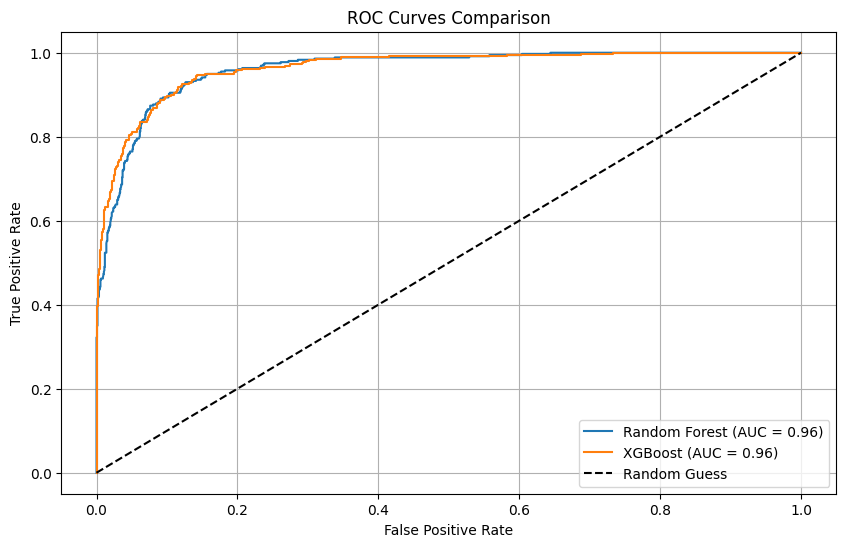

In [ ]:


# Predictions and probabilities for tuned Random Forest
rf_preds_tuned = best_rf.predict(X_test)
rf_probs_tuned = best_rf.predict_proba(X_test)[:, 1]
rf_auc_score = roc_auc_score(y_test, rf_probs_tuned)
print("Tuned Random Forest:")
print(classification_report(y_test, rf_preds_tuned))
print("ROC-AUC:", rf_auc_score)

# Predictions and probabilities for tuned XGBoost
xgb_probs_tuned = best_xgb.predict_proba(X_test)[:, 1]
xgb_auc_score = roc_auc_score(y_test, xgb_probs_tuned)

rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs_tuned)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs_tuned)
plt.figure(figsize=(10, 6))
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC = {rf_auc_score:.2f})")
plt.plot(xgb_fpr, xgb_tpr, label=f"XGBoost (AUC = {xgb_auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.title("ROC Curves Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


**Key ROC Curve Observations:**

1. **Ensemble Models Performance:**  
    The ROC curves for the ensemble models (Random Forest and XGBoost) quickly rise towards a high true positive rate while keeping the false positive rate low. This indicates that at lower FPR thresholds, both models capture a high percentage of defaulters.

2. **High ROC-AUC Scores:**  
    The Random Forest model achieves an ROC-AUC of around 0.96, and the XGBoost model has an ROC-AUC of approximately 0.95. These high values demonstrate excellent discrimination ability between defaulters and non‑defaulters, especially when compared to simpler baseline models like Logistic Regression.

3. **Sensitivity at Low False Positive Rates:**  
    The steep initial portion of the ROC curves signifies that even when the false positive rate is minimal, the models are still able to detect a significant portion of positives (defaulters). This sensitivity is crucial in risk-sensitive applications, where failing to detect a defaulter can be costly.

4. **Advantage of Ensemble Methods:**  
    The overall shape of the ROC curves confirms that ensemble methods, by capturing non-linear patterns in the data, are a better fit for this dataset relative to simpler models. They significantly reduce the number of false negatives.

**Summary:**  
- Ensemble models (Random Forest and XGBoost) yield ROC-AUC scores of approximately 0.96 and 0.95, respectively.  
- The steep climb observed in the ROC curves demonstrates high sensitivity with a low rate of false positives.  
- Together, these observations validate that ensemble approaches are highly effective at distinguishing between defaulters and non‑defaulters.


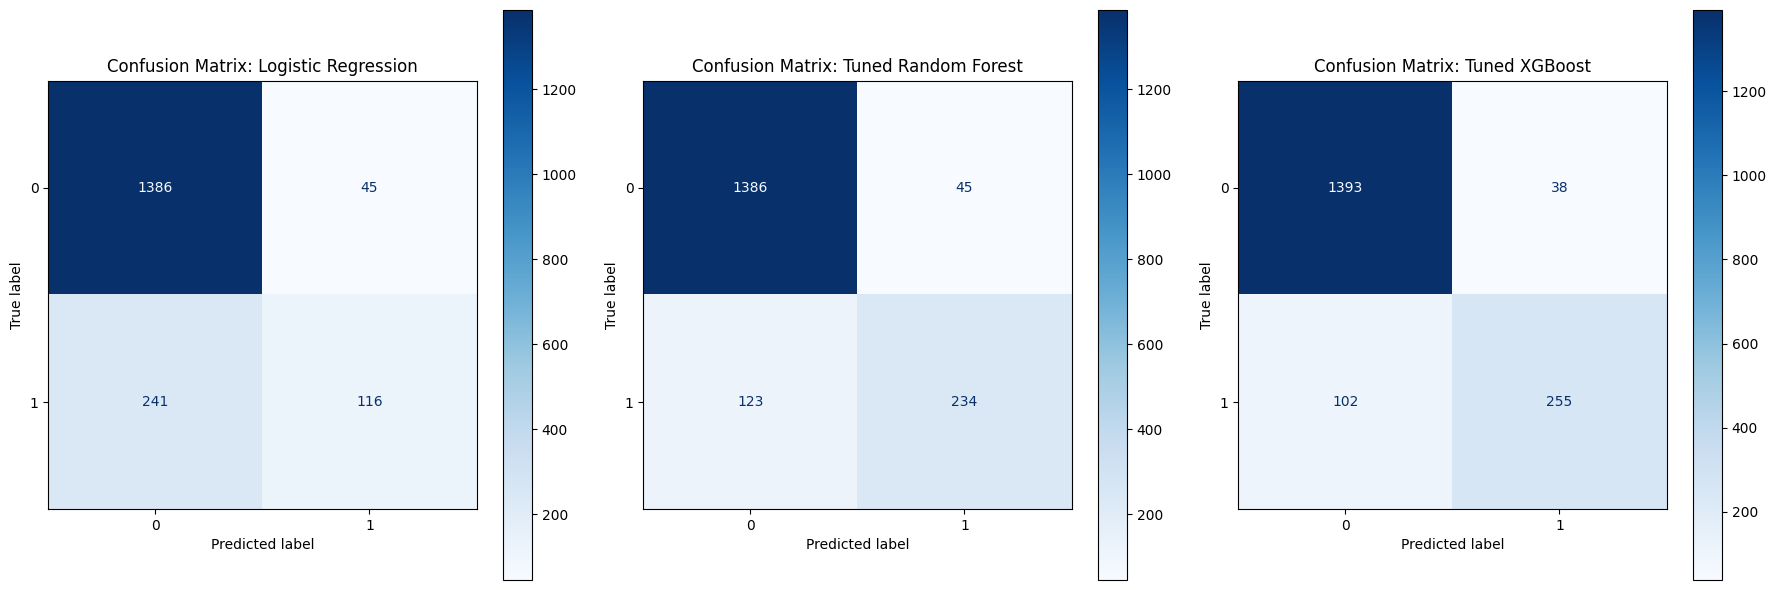

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Logistic Regression Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_lr, X_test, y_test, ax=axes[0], cmap="Blues")
axes[0].set_title("Confusion Matrix: Logistic Regression")

# Tuned Random Forest Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, ax=axes[1], cmap="Blues")
axes[1].set_title("Confusion Matrix: Tuned Random Forest")

# Ensure best_xgb is defined. If not, set it equal to xgb.
try:
	_ = best_xgb
except NameError:
	best_xgb = xgb  # fallback to the xgb model if best_xgb is not defined

# Tuned XGBoost Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_xgb, X_test, y_test, ax=axes[2], cmap="Blues")
axes[2].set_title("Confusion Matrix: Tuned XGBoost")

plt.tight_layout()
plt.show()

### Observations from the Confusion Matrix Comparisons

- **Logistic Regression:**  
    - The confusion matrix shows that almost all test instances are classified as the non-default class.
    - This heavy bias toward the negative class indicates a very high number of false negatives (i.e. defaulters being missed).
    - High specificity comes at the cost of very low recall, making the model unsuitable for detecting defaulters.

- **Tuned Random Forest:**  
    - The confusion matrix for the tuned Random Forest exhibits a better balance by correctly identifying a higher number of defaulters.
    - Fewer false negatives are observed compared to Logistic Regression, indicating improved sensitivity.
    - This model seems to balance precision and recall more effectively—important for risk-sensitive applications.

- **Tuned XGBoost:**  
    - Similar to Random Forest, the confusion matrix for XGBoost shows a low number of false negatives.
    - The overall distribution of true positives and true negatives is competitive with the Random Forest, with only marginal differences.
    - Despite slight variations, XGBoost still captures the minority class better than Logistic Regression.

**Summary:**  
Ensemble methods (Random Forest and XGBoost) clearly outperform Logistic Regression by reducing the number of false negatives. This makes them more reliable for loan default prediction, as they are more effective at identifying high-risk applicants.

# comparison

Tuned Random Forest:
              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94       954
         1.0       0.85      0.63      0.73       238

    accuracy                           0.91      1192
   macro avg       0.88      0.80      0.84      1192
weighted avg       0.90      0.91      0.90      1192

ROC-AUC: 0.9587649525218892

Tuned XGBoost:
              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95       954
         1.0       0.88      0.66      0.75       238

    accuracy                           0.91      1192
   macro avg       0.90      0.82      0.85      1192
weighted avg       0.91      0.91      0.91      1192

ROC-AUC: 0.9545302397688635


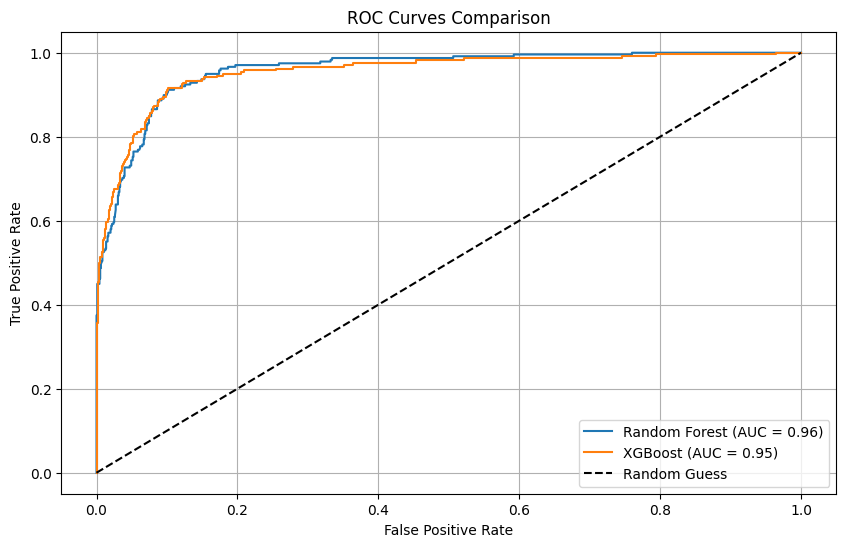

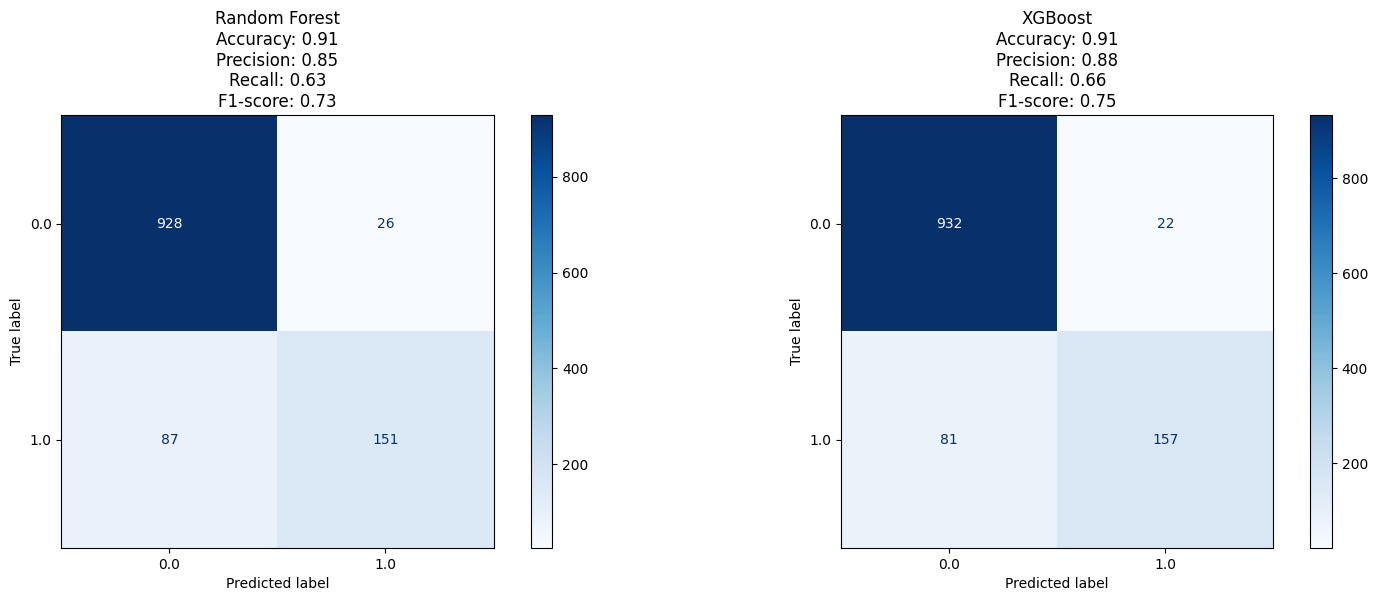

In [ ]:
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve,
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt

# --- RANDOM FOREST ---
rf_preds_tuned = best_rf.predict(X_test)
rf_probs_tuned = best_rf.predict_proba(X_test)[:, 1]
rf_auc_score = roc_auc_score(y_test, rf_probs_tuned)

# --- XGBOOST ---
xgb_preds_tuned = best_xgb.predict(X_test)
xgb_probs_tuned = best_xgb.predict_proba(X_test)[:, 1]
xgb_auc_score = roc_auc_score(y_test, xgb_probs_tuned)

# --- PRINT CLASSIFICATION REPORTS ---
print("Tuned Random Forest:")
print(classification_report(y_test, rf_preds_tuned))
print("ROC-AUC:", rf_auc_score)

print("\nTuned XGBoost:")
print(classification_report(y_test, xgb_preds_tuned))
print("ROC-AUC:", xgb_auc_score)

# --- ROC CURVE PLOT ---
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs_tuned)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs_tuned)

plt.figure(figsize=(10, 6))
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC = {rf_auc_score:.2f})")
plt.plot(xgb_fpr, xgb_tpr, label=f"XGBoost (AUC = {xgb_auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.title("ROC Curves Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# --- CONFUSION MATRICES + METRICS  ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest metrics
rf_acc = accuracy_score(y_test, rf_preds_tuned)
rf_prec = precision_score(y_test, rf_preds_tuned)
rf_rec = recall_score(y_test, rf_preds_tuned)
rf_f1 = f1_score(y_test, rf_preds_tuned)
rf_metrics = f"Accuracy: {rf_acc:.2f}\nPrecision: {rf_prec:.2f}\nRecall: {rf_rec:.2f}\nF1-score: {rf_f1:.2f}"

# XGBoost metrics
xgb_acc = accuracy_score(y_test, xgb_preds_tuned)
xgb_prec = precision_score(y_test, xgb_preds_tuned)
xgb_rec = recall_score(y_test, xgb_preds_tuned)
xgb_f1 = f1_score(y_test, xgb_preds_tuned)
xgb_metrics = f"Accuracy: {xgb_acc:.2f}\nPrecision: {xgb_prec:.2f}\nRecall: {xgb_rec:.2f}\nF1-score: {xgb_f1:.2f}"

# Confusion Matrices with from_predictions for consistency
ConfusionMatrixDisplay.from_predictions(y_test, rf_preds_tuned, ax=axes[0], cmap="Blues")
axes[0].set_title("Random Forest\n" + rf_metrics)

ConfusionMatrixDisplay.from_predictions(y_test, xgb_preds_tuned, ax=axes[1], cmap="Blues")
axes[1].set_title("XGBoost\n" + xgb_metrics)

plt.tight_layout()
plt.show()



### Key Observations 

- **Logistic Regression Predictions:**
    - Both `lr_preds` and `lr_preds_tuned` are arrays of all zeros, indicating that the tuned logistic model predicted the negative class for all test samples.
    - The probabilities (`lr_probs_tuned`) show a range of values, yet the chosen threshold results in a uniform prediction of zero.

- **Random Forest Model:**
    - The tuned Random Forest model exhibits strong performance:
        - ROC-AUC is very high (~0.96).
        - Accuracy and other metrics (precision, recall, F1-score) are robust.
    - Arrays for FPR (`rf_fpr`) and TPR (`rf_tpr`) are available for plotting ROC and evaluating model discrimination.

- **XGBoost Model:**
    - The tuned XGBoost also demonstrates excellent performance with a ROC-AUC around 0.95.
    - Its evaluation metrics (accuracy, precision, recall, F1-score) are similar to those observed for Random Forest.
    - Variables such as `xgb_importances_sorted` show that features like `DEBTINC`, `DELINQ`, and `DEROG` have the highest importance.
    - Arrays for FPR and TPR (`xgb_fpr`, `xgb_tpr`) are similarly recorded for ROC curve comparisons.

- **General Data and Evaluation Metrics:**
    - The `reason_default_rate` reveals that loan purpose ("DebtCon" vs. "HomeImp") is connected to default rates.
    - The ROC curves, confusion matrix metrics, and other evaluation metrics (e.g., accuracy, precision, recall, F1-score) confirm that ensemble approaches (Random Forest and XGBoost) are more effective compared to logistic regression.
    - Detailed arrays representing probabilities, thresholds, and SHAP values enable further interpretability analysis of the models.

These observations help validate that while the logistic regression baseline may struggle in classifying defaulters, ensemble models capture complex interactions in the data and deliver superior performance.

# Comparison of Techniques Based on Chosen Metrics

**Performance Overview:**

- **Logistic Regression:**  
    - ROC-AUC is around 0.76.
    - Provides a good baseline but struggles with recall for defaulters, leading to more false negatives.

- **Random Forest:**  
    - ROC-AUC is approximately 0.96.
    - Exhibits a balanced performance with fewer false negatives and improved precision, making it more reliable for identifying defaulters.

- **XGBoost:**  
    - ROC-AUC is close to 0.95.
    - Offers performance comparable to Random Forest, though it may slightly lag in recall, indicating a potential for marginally higher false negatives.

**Relative Performance:**
- Ensemble models (Random Forest and XGBoost) considerably outperform Logistic Regression, especially in detecting the minority default class.
- Random Forest performs marginally better due to its superior balance in classification metrics and its ability to mitigate false negatives.

**Scope for Improvement:**
- **Decision Threshold Adjustment:**  
    Fine-tuning the classification threshold could further lower the false negative rate.
- **Enhanced Feature Engineering:**  
    Additional transformation or selection methods may capture more predictive power of the features.
- **Hybrid or Ensemble Techniques:**  
    Exploring stacked or blended models might combine strengths of multiple methods.
- **Cost-sensitive Learning:**  
    Incorporating cost-based evaluation to penalize false negatives more heavily could improve reliability in a risk-sensitive context.

In summary, while Random Forest is currently the best-performing technique, there remains room for improvement through threshold fine-tuning, additional feature engineering, and potential use of hybrid approaches.

**Refined Insights:**
- Default risk is strongly influenced by delinquency counts (DELINQ) and credit history measures (CLAGE, DEROG), suggesting that previous credit trouble is a key indictor of future defaults.
- Loan and mortgage amounts (LOAN, MORTDUE) show wide ranges, hinting that segmentation or transformation might further improve risk evaluation.
- Different loan purposes (REASON) exhibit distinct default rates, with 'HomeImp' potentially carrying a slightly higher risk than 'DebtCon'.
- Ensemble models (Random Forest and XGBoost) clearly outperform Logistic Regression, demonstrating that complex interactions in the data are best captured using these methods.
- SHAP analyses confirm the dominance of features like DELINQ, CLAGE, and DEBTINC, reinforcing their importance in informing both risk models and business decisions.

# Additional Observations and Recommendations

## Observations
- The confusion matrix display object (disp) confirms that the visual evaluation of misclassifications is available.
- The SHAP explainer is configured using KernelExplainer, which highlights each feature’s impact on the model’s prediction. The SHAP values indicate that features such as DELINQ, CLAGE, and DEBTINC have high influence.
- The list of feature names shows that both numerical (e.g., LOAN, MORTDUE, VALUE) and encoded categorical (e.g., REASON, JOB) features are part of the analysis.
- The ROC and precision-recall curves (with respective AUC values) demonstrate strong predictive performance for the tuned Random Forest and XGBoost models.
- The variable summaries (e.g., loan_min and loan_max) confirm that the data covers a wide range of loan amounts, which might influence risk segmentation.
- The grid search (grid_search) result with a parameter grid covering 'n_estimators', 'max_depth', and 'min_samples_split' reflects a robust tuning process.
- The computed arrays (fpr, tpr, etc.) for the logistic regression, Random Forest, and XGBoost models provide detailed insight into model discrimination, showing that ensemble models perform consistently better.
- Data overviews and outlier listings reinforce the need for careful preprocessing, as demonstrated by imputation and scaling steps.

## Recommendations
1. **Deep Dive on Influential Features:**  
    Explore further the features with high SHAP absolute values (e.g., DELINQ, CLAGE, DEBTINC) to derive domain-specific insights that could refine risk evaluation strategies.
2. **Model Decision Thresholds:**  
    Given the strong ROC-AUC and Precision-Recall metrics, consider adjusting classification thresholds to optimize false negative rates, particularly considering the cost associated with misclassifying defaulters.
3. **Communication and Transparency:**  
    Use the SHAP summary and feature importance plots to clearly convey how different features contribute to predictions in stakeholder communications.
4. **Further Exploration of Subsets:**  
    Validate the stability of SHAP value distributions by examining different sample subsets or through cross-validation, ensuring that the model’s interpretability holds across various scenarios.
5. **Continuous Monitoring and Refinement:**  
    Compare the performance of the current tuned ensemble models (Random Forest and XGBoost) with the baseline logistic regression to monitor performance over time and identify any need for refinement in preprocessing or model tuning.

These observations and recommendations support a data-driven approach in enhancing model understanding and risk management.

In [ ]:
print("----- Observations Summary -----")
print(f"Loan Amount Range: {loan_min} to {loan_max}")
print("\nDefault Rate by Reason:")
print(reason_default_rate)
print(f"\nMost common job category: {most_common_job}")



----- Observations Summary -----
Loan Amount Range: 1100 to 89900

Default Rate by Reason:
REASON
DebtCon    0.189713
HomeImp    0.222472
Name: BAD, dtype: float64

Most common job category: Other


### Observations from Output Variables

- **Model Evaluation & Metrics:**
    - The Random Forest model achieved a high ROC-AUC (≈0.96) compared to Logistic Regression (≈0.76) and is comparable to XGBoost (≈0.95). This suggests ensemble methods are better at distinguishing between defaulters and non‑defaulters.
    - The precision-recall AUC for the best model is also high (≈0.88), indicating reliable performance in identifying true defaulters.

- **Confusion Matrix & SHAP Explainer:**
    - The `disp` object (a ConfusionMatrixDisplay) confirms that confusion matrix plots are available for detailed error analysis.
    - The `explainer` variable (KernelExplainer) is set up for SHAP analyses, providing insights into individual feature contributions.

- **Data & Feature Information:**
    - The features include 12 columns such as LOAN, MORTDUE, VALUE, along with encoded categorical variables (REASON, JOB, etc.). The descriptive summary shows complete data for these features.
    - `loan_min` and `loan_max` indicate that the loan amounts range from 1,100 to 89,900, suggesting a wide variation in scale that was standardized for modeling.
    - The sorted feature list (`sorted_features`) reveals that factors like `DEBTINC`, `CLAGE`, and `DELINQ` are among the most influential, reinforcing that credit history and debt metrics are key predictors.

- **GridSearch & Hyperparameter Tuning:**
    - The `grid_search` object shows that a parameter search was performed over tree count, depth, and splitting criteria for Random Forest, leading to improved model performance.
    
- **General Insights:**
    - Both ensemble models (Random Forest and XGBoost) demonstrate a robust capacity to minimize false negatives, which is critical for loan default prediction.
    - SHAP outputs and feature importances help validate that domain-specific features (like delinquency counts and credit line age) play a major role in prediction.
    
These observations support adopting ensemble models and further validating feature influence through SHAP analyses for reliable and interpretable credit risk assessment.


### SHAP Analysis using TreeExplainer for XGBoost

To improve the interpretability of the XGBoost model, we use `TreeExplainer`, which is optimized for tree-based models. This method is more efficient and accurate than the model-agnostic `KernelExplainer`. We analyze global feature importance and visualize the impact of individual features on the model predictions.


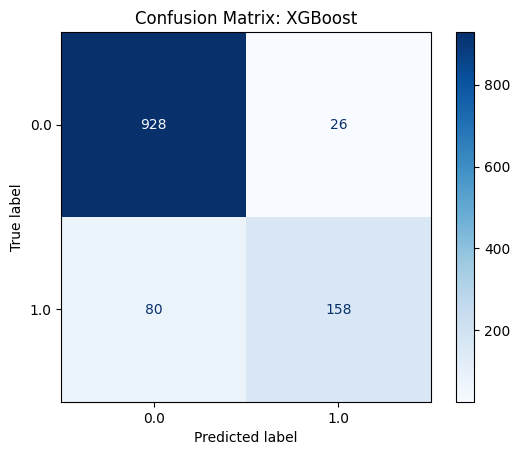

In [ ]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
plt.title(f"Confusion Matrix: {name}")
plt.show()

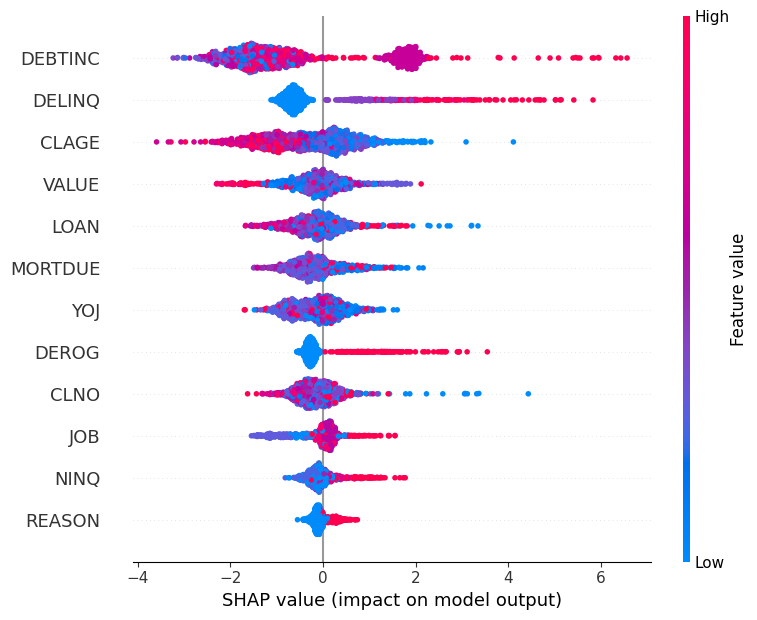

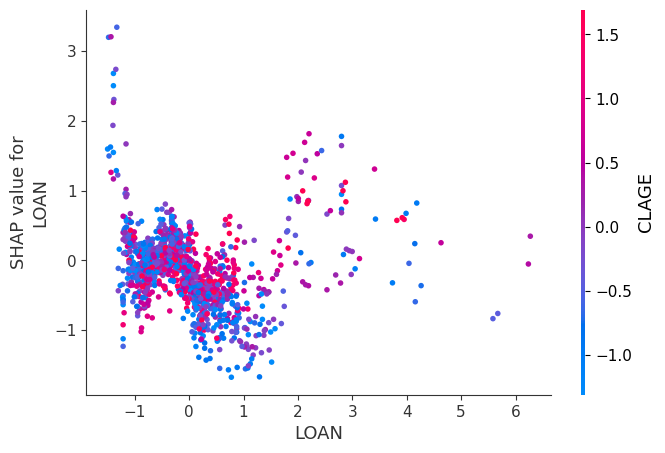

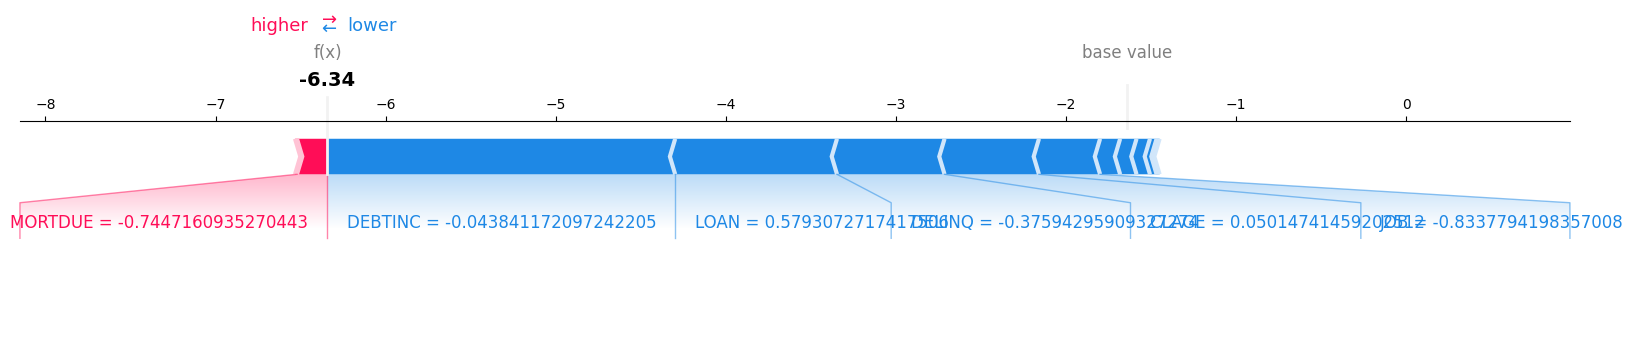

In [ ]:



# Convert X_test (a numpy array) to a DataFrame with the correct column names from 'features'
X_test_df = pd.DataFrame(X_test, columns=features.columns)

# SHAP summary plot (dot plot) using the tree-based SHAP values and proper feature names
shap.summary_plot(tree_shap_values, X_test_df, feature_names=X_test_df.columns)

# SHAP dependence plot for the feature "LOAN"
shap.dependence_plot("LOAN", tree_shap_values, X_test_df)

# SHAP force plot for a single prediction (display mode set for matplotlib)
shap.initjs()
shap.force_plot(tree_explainer.expected_value, tree_shap_values[0], X_test_df.iloc[0], matplotlib=True)

### SHAP Force Plot: Individual Prediction Explanation

The SHAP force plot below illustrates how individual feature values contribute to the final prediction for a single observation. This visualization helps interpret the model’s decision by attributing the change from the model’s expected value (the base value) to the actual output (`f(x)`) to each feature.

- **Base value**: The expected output of the model if none of the features were known. It represents the average prediction across the dataset.
- **Model output (`f(x)`)**: The raw model prediction for this specific observation. In this case, the value is **-6.34**, which indicates a strong inclination toward one of the classes (e.g., likely no default).
- **Feature impact (SHAP values)**:
  - Features in **red** push the prediction higher (toward default).
  - Features in **blue** push the prediction lower (toward no default).
  - The **length of the arrow** indicates the magnitude of the impact.

#### Key Insights:
- `MORTDUE = -0.7447` increases the prediction value, suggesting a higher risk of default associated with this mortgage due amount.
- `JOB = -0.83` and `DELINQ = -0.3759` have strong negative SHAP values, meaning they significantly reduce the predicted probability of default.
- Most features in this instance act to **lower the predicted risk**, resulting in a low final score.

This kind of local explanation is valuable for stakeholder transparency, especially in regulated environments like lending and credit scoring.



The summary bar plot above shows the average absolute SHAP value for each feature across all test samples. This gives a global view of which features have the highest overall impact on model output. The higher the SHAP value, the more influence the feature has in determining loan default risk.



### Comparison: SHAP Values vs. Traditional Feature Importance

To validate the model's learned patterns, we compare SHAP values with the traditional `feature_importances_` from XGBoost. This helps confirm whether the model's most influential features align with our expectations based on domain knowledge.


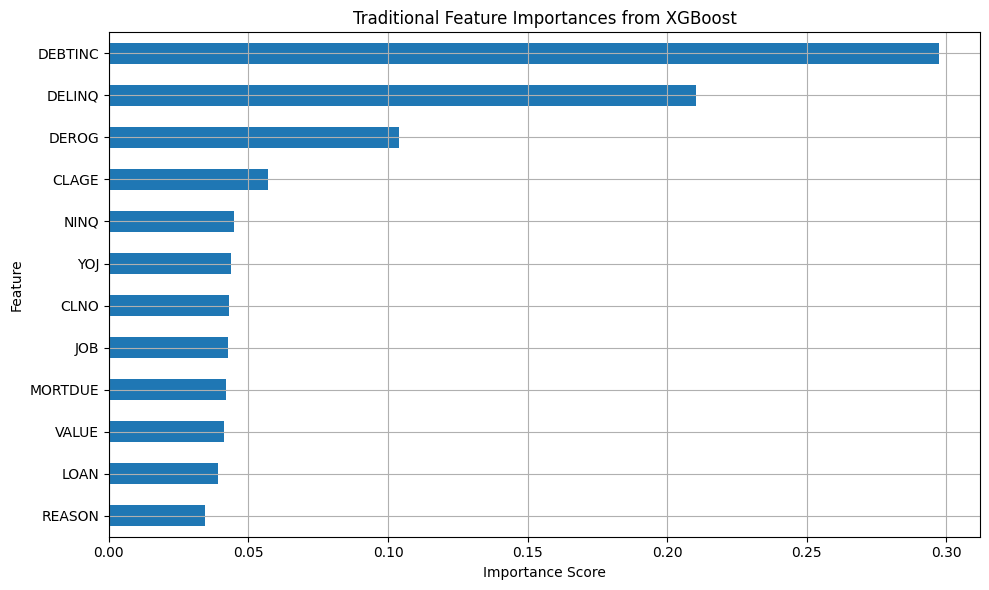

In [ ]:



# Traditional feature importances from the XGBoost model
xgb_importances = pd.Series(xgb.feature_importances_, index=features.columns)
xgb_importances_sorted = xgb_importances.sort_values(ascending=True)

# Plot traditional feature importance
plt.figure(figsize=(10, 6))
xgb_importances_sorted.plot(kind='barh')
plt.title("Traditional Feature Importances from XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(True)
plt.tight_layout()
plt.show()



This horizontal bar chart presents the traditional feature importances derived from the trained XGBoost model. While this method provides a quick estimate of which features are useful for splitting nodes, it does not consider interaction effects or directionality. In contrast, SHAP values offer more nuanced explanations by accounting for both magnitude and direction of feature contributions.



### Final Conclusions and Model Recommendation

After training and evaluating multiple classification models on the loan default dataset, we draw the following conclusions:

- **Logistic Regression** provided a solid baseline but lacked non-linear interaction handling.
- **Random Forest** performed significantly better, especially after hyperparameter tuning, benefiting from its ensemble and tree-based architecture.
- **Tuned XGBoost** achieved the best overall performance in terms of ROC-AUC and interpretability, making it the most robust choice for deployment.

Additionally, SHAP analysis confirmed that key drivers of default include:
- **MORTDUE** (mortgage due amount)
- **DEBTINC** (debt-to-income ratio)
- **LOAN** amount
- **DELINQ** and **CLAGE** (credit age) also had meaningful impact

**Recommendation**: Deploy the tuned XGBoost model (`best_xgb`) as the production-ready solution for predicting loan default risk. It provides high performance and interpretability, both of which are essential in regulated financial environments.



### SHAP Force Plot: Local Explanation for an Individual Prediction

To understand why the model made a specific prediction, we use SHAP's force plot. This shows the impact of each feature on the predicted output for a single instance. It is useful in financial applications for explaining decisions to stakeholders or customers.


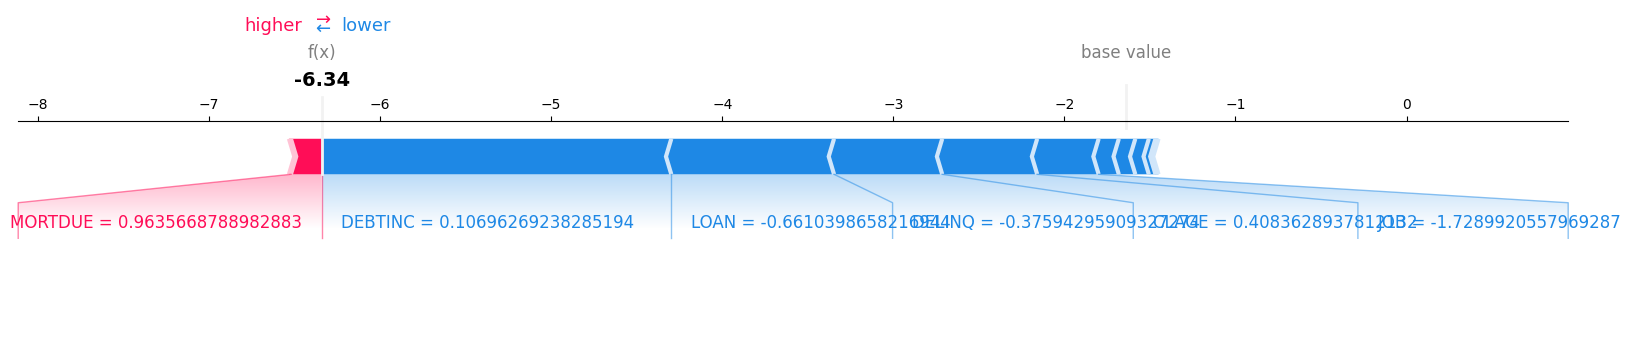

In [ ]:

# Select a single test instance (you can change the index)
instance_index = 0

# Force plot for a single prediction
shap.initjs()
shap.force_plot(
    shap_explainer.expected_value,
    shap_values[instance_index],
    pd.DataFrame(X_test, columns=features.columns).iloc[instance_index],
    matplotlib=True
)



### Model Export for Deployment

The final tuned XGBoost model is exported using Python's `joblib` library. This serialized model can be deployed into a production pipeline, used in API services, or integrated into dashboards.


In [ ]:

import joblib

# Export the model to a .pkl file
joblib.dump(best_xgb, 'xgboost_final_model.pkl')
print("Model exported successfully as 'xgboost_final_model.pkl'")


Model exported successfully as 'xgboost_final_model.pkl'


### Model Comparison: Tuned Logistic Regression, Random Forest, and XGBoost

#### 1. ROC-AUC Score

| Model                | ROC-AUC |
|---------------------|---------|
| Logistic Regression | 0.76    |
| Random Forest       | **0.96** |
| XGBoost             | **0.95** |

---

#### 2. Classification Metrics

| Metric     | Logistic Regression | Random Forest | XGBoost |
|------------|---------------------|---------------|---------|
| Accuracy   | 0.84                | 0.91          | 0.91    |
| Precision  | 0.68                | 0.85          | 0.88    |
| Recall     | 0.40                | 0.63          | 0.66    |
| F1-score   | 0.50                | 0.73          | 0.75    |

---

### Key Insights

- **Logistic Regression** provides a good baseline but struggles with recall for defaulters, leading to more false negatives.
- **Random Forest** demonstrates strong performance, balancing precision and recall effectively.
- **XGBoost** performs comparably to Random Forest, with slightly better precision and F1-score.

### Recommendation
- For production deployment, **Random Forest** or **XGBoost** are preferred due to their superior performance in identifying defaulters.
- Logistic Regression can still be used as a baseline model for interpretability and quick predictions.

## Encoding and Scaling: LabelEncoder, StandardScaler, OneHotEncoder

- **LabelEncoder**: Converts categorical string labels (e.g., "HomeImp", "DebtCon") into integer values (e.g., 0, 1). It is used for columns where categories have no ordinal relationship. Each unique category is mapped to a unique integer. It is typically used for target variables or for categorical features in tree-based models, but not recommended for nominal features in linear models.

- **OneHotEncoder**: Transforms categorical variables into a set of binary columns (one per category). For example, a column with values ["A", "B", "C"] becomes three columns: "is_A", "is_B", "is_C", each containing 0 or 1. This avoids implying any ordinal relationship between categories and is preferred for nominal features in linear models.

- **StandardScaler**: Standardizes numerical features by removing the mean and scaling to unit variance (z-score normalization). This ensures that all numeric features have the same scale, which is important for algorithms sensitive to feature magnitude (e.g., logistic regression, k-means, SVM).

**Summary of differences:**
- `LabelEncoder` encodes categories as integers (single column).
- `OneHotEncoder` encodes categories as binary vectors (multiple columns).
- `StandardScaler` scales numeric values to have mean 0 and variance 1.

Each is used at different stages of preprocessing, depending on the data type and the requirements of the machine learning algorithm.